This continues from DB_Reaxys and supplements the database with active fragment/carrier fragment labels

In [3]:
# Allow more than one output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.8.5
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.23
       base environment : /home/aa2133/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                          /home/aa2133/.conda/pkgs
       envs directories : /home/aa2133/miniconda3/envs
                          /home/aa2133/.conda/envs
               platform : linux-64
             user-agent : conda/4.8.5 requests/2.

# Dependencies

In [2]:
import shutil
import itertools
import copy
from MainFunctions import writepickle, openpickle
from collections import Counter, namedtuple
from rdkit.Chem import BRICS  # For fragmenting
from ttictoc import tic, toc
from rxnmapper import RXNMapper  # Importing RXNMapper for unsupervised atom mapping
import os  # Working with the OS
from PIL import Image  # Working with images
from IPython.display import SVG  # For SVG support
from rdkit.Chem.Draw import rdMolDraw2D  # Drawing 2D molecules/reactions
from rdkit.Chem import rdChemReactions  # Reaction processing
from rdkit.Chem import Draw  # For drawing molecules/reactions
from rdkit.Chem import AllChem  # Overall support
from rdkit import Chem  # Importing RDKit
from FindFunctionalGroups import identify_functional_groups as IFG
from helpCompound import hc_smilesDict, hc_molDict
import cairosvg
import json
from chempy import balance_stoichiometry
import io
import matplotlib.pyplot as plt
from IPython.display import display, Image
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import RDConfig
import cirpy
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PeriodicTable, GetPeriodicTable
from rdkit.Chem import FunctionalGroups
import sys
sys.path.append('/home/aa2133/Impurity-Project')
sys.path.append('/home/aa2133/Impurity-Project/getCandiRxns')
try:
    import pickle5 as pickle  # Only if pickle doesn't work
except Exception:
    import pickle

In [4]:
%%writefile FunctionsDB.py

import shutil
import itertools
import copy
from MainFunctions import writepickle, openpickle
from collections import Counter, namedtuple

from rdkit import Chem  # Importing RDKit
from rdkit.Chem.Draw import rdMolDraw2D  # Drawing 2D molecules/reactions
from rdkit.Chem import rdChemReactions  # Reaction processing
from rdkit.Chem import Draw  # For drawing molecules/reactions
from rdkit.Chem import AllChem  # Overall support
from FindFunctionalGroups import identify_functional_groups as IFG

import sqlite3
import os
import dask.delayed as delayed
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import numpy as np
import pandas as pd

#%% Building basic substance database

def info(molfile):
    mol = Chem.MolFromMolFile(molfile)
    if mol:
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
        smils = Chem.MolToSmiles(mol)
        return mol, smils
    else:
        return molfile


def basic(ID, folder):
    if str.isdecimal(ID):
        molfileaddress = folder+os.sep+ID
        try:
            res = info(molfileaddress)
        except Exception as e:
            error = e
            compaddrs = {'SubstanceID': int(
                ID), 'MolFileAddress': molfileaddress, 'Error': error}
        else:
            if type(res) == tuple:
                smiles = res[1]
                compaddrs = {'SubstanceID': int(
                    ID), 'MolFileAddress': molfileaddress, 'Smiles': smiles}
            else:
                error = 'Valence error'
                compaddrs = {'SubstanceID': int(
                    ID), 'MolFileAddress': molfileaddress, 'Error': error}
    else:
        compaddrs = {}
    return compaddrs


def basicgroup(molfilelist, folder):
    return [basic(ID, folder) for ID in molfilelist]


def substancedblist(folderName, partitions):
    dem = os.listdir(folderName)
    b = db.from_sequence(dem, npartitions=partitions)
    dflist = b.map_partitions(basicgroup, folderName).compute()
    return dflist


#%% Fragment detection

def getCarrierFrags(smi, size, resFormat='smarts', addHs=True):
    """
    str (smiles), int -> list (str_smiles/smarts) 
    smi: str, smiles of a compound
    size: size of carrier fragments, number atoms
    resFormat: 'smiles' or 'smarts'
    addHs: bool, if True H will be consider for generation of substructure, recommend True
            otherwise terminal atoms of a molecule are not differentiated with other atoms
    this function return list of strings of smarts representing carrier frags with miniSize of size
    a carrier frag carries a functional group defined by using Ertl's method
    find out the bonds to cut define a cutter to cut out the target fragments based on bonds to cut
    1) get a list of function groups using IFG
    2) if IFG list empty meaning no functional groups, directly return compound smiles
    3) evaluate the size of current fragment,  
       if frag_size >= size, directly return the comp smile
       if frag_size < miniSizeFrag, expand the fragment by searching for neighors, only use terminal atoms to search
       repeat expansion till frag_size >= size
    """
    mol = Chem.MolFromSmiles(smi)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    if addHs:
        mol = Chem.AddHs(mol)
    # -- get the list of functional groups FG
    # e.g., [IFG(atomIds=(1, 4, 7), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(10,), atoms='O', type='cO')]
    IFG_ls = IFG(mol)
    # if IFG_ls is empty, directly return this compounds
    if len(IFG_ls) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    # -- get atomIDs (FGs_atomIDs_expan) and terminalAtomIDs (FGs_terminal_atomIDs) for all frags
    FGs_atomIDs = [_.atomIds for _ in IFG_ls]  # e.g., [(1, 4, 7), ...]
    n_FGs = len(FGs_atomIDs)
    # expan all FGs that < size # e.g., [[1, 4, 7, 8, 9], ...]
    FGs_atomIDs_expan = [None]*n_FGs
    # terminal atoms: atoms on which bonds to cut will be searched
    # [[2, 3, 8], ...] or [[], [], ...], note [2, 3, 8] are terminal of comp not frag
    FGs_terminal_atomIDs = [None]*n_FGs
    for i in range(n_FGs):
        # initialization before search and expand fragments
        FG_atomIDs = list(FGs_atomIDs[i])  # e.g., [1, 4, 7]
        FG_size = len(FG_atomIDs)
        # find initial terminal atoms
        # terminal atoms: atoms with neis that not belong to FG_atomIDs
        # note terminal atoms here are terminal of fragments not comp
        # C=O has no fragment terminal, but both C and O are comp terminals
        # there are 3 cases that no fragment terminal ie, FG_terminal_atomIDs = [] one case FG_terminal_atomIDs not empty
        # case 1: FG_size < size, and FG_terminal_atomIDs = [], ie., comp too small, no chane to expand e.g., C=O, HCl, HNO3
        # case 2: FG_size < size, and FG_terminal_atomIDs = [2,3,8],
        #         got chane to expand, but after expand still cannot reach size, e.g., OCC=O
        #         eventually FG_terminal_atomIDs = []
        # case 3: FG_size >= size, and FG_terminal_atomIDs = [], cos the whole big comp is a functional group
        # for all above cases the original comp will be return
        # two case FG_terminal_atomIDs is not empty, cutting will performed based on FG_terminal_atomIDs
        # case 4: FG_size >= size, and FG_terminal_atomIDs = [2,3,8], just cut using FG_terminal_atomIDs
        # case 5: FG_size < size, and FG_terminal_atomIDs = [2,3,8], after expand, size reached and FG_terminal_atomIDs changed
        FG_terminal_atomIDs = []  # e.g., [2, 3, 8] or [], HNO3 or C=O -> []
        for atomID in FG_atomIDs:
            neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
            if len(set(neis_IDs) - set(FG_atomIDs)) != 0:
                FG_terminal_atomIDs = FG_terminal_atomIDs + [atomID]
        # perform search / expand fragments
        # [],  case 1 cannot expand, although FG_size < size
        if (FG_size >= size) | (len(FG_terminal_atomIDs) == 0):
            # make sure all elements in FGs_atomIDs_expan are lists
            FGs_atomIDs_expan[i] = FG_atomIDs
            FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
            # case 3 still could be [] even if FG_size >= size, though less likely
        else:
            # init FG to be expand
            FG_expan_atomIDs = copy.deepcopy(FG_atomIDs)  # e.g., [1, 4, 7]
            # max repeat size times, since repeat size should reach the size
            for rep in range(size):
                FG_expan_atomIDs_old = copy.deepcopy(FG_expan_atomIDs)
                # not all atoms need be searched for neis, only ones not in FG_expan_atomIDs for each epoch
                for atomID in FG_terminal_atomIDs:
                    neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
                    FG_expan_atomIDs = FG_expan_atomIDs + neis_IDs
                FG_expan_atomIDs = list(set(FG_expan_atomIDs))
                FG_terminal_atomIDs = list(set(FG_expan_atomIDs)-set(FG_expan_atomIDs_old))
                if len(FG_terminal_atomIDs) == 0:  # cannot expand due to small comp size
                    FGs_atomIDs_expan[i] = FG_expan_atomIDs
                    FGs_terminal_atomIDs[i] = FG_terminal_atomIDs  # [] case 2
                    break  # for expan of next FG
                if len(FG_expan_atomIDs) >= size:  # reach the desired size
                    FGs_atomIDs_expan[i] = FG_expan_atomIDs
                    FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
                    break
    # it seems not possible that [[2, 3, 8], [], ...], if there one [] then all should be [],
    # either [[]] or [[], [], ...] (i.e., small comp with single or multiple FGs)
    # sum([len(_) for _ in FGs_terminal_atomIDs]) == 0:
    if len(FGs_terminal_atomIDs[0]) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    else:
        FGs_strs = []  # smiles or smarts
        for FG_atomIDs in FGs_atomIDs_expan:
            if resFormat == 'smiles':
                FGs_str = Chem.MolFragmentToSmiles(mol, FG_atomIDs, canonical=True)
                FGs_strs = FGs_strs + [FGs_str]
            elif resFormat == 'smarts':
                FGs_str = Chem.MolFragmentToSmarts(mol, FG_atomIDs, isomericSmarts=False)
                FGs_strs = FGs_strs + [FGs_str]
        return FGs_strs
    
#%% Adding fragment smarts column accounting for mixtures
def getfrags(series,natoms):
#     smiles=series['Smiles']
#     if smiles=='Error':
#         return pd.DataFrame({'FragmentSmarts':['Error'],'FragmentSmiles':['Error']})
#     if series['>1 Compound']==True: #This compound is a mixture. Need to split and apply getcarrierfrags to each smiles
#         fragsmarts=getmixturefrags(smiles,natoms)
#     else:
#         try:
#             fragsmarts=getCarrierFrags(smiles,natoms)
#         except Exception:
#             return pd.DataFrame({'FragmentSmarts':['Error'],'FragmentSmiles':['Error']})
#     if type(fragsmarts)==list:
#         fragsmiles=[getfragsmiles(fragsmart) for fragsmart in fragsmarts]
#     else:
#         fragsmiles=getfragsmiles(fragsmarts)
#     return pd.DataFrame({'FragmentSmarts':[fragsmarts],'FragmentSmiles':[fragsmiles]})

    smiles=series['Smiles']
    if smiles=='Error':
        return 'Error'
    if series['>1 Compound']==True: #This compound is a mixture. Need to split and apply getcarrierfrags to each smiles
        fragsmarts=getmixturefrags(smiles,natoms)
    else:
        try:
            fragsmarts=getCarrierFrags(smiles,natoms)
        except Exception:
            return 'Error'
    return fragsmarts
        
    
def getfragpartition(partition,natoms):
    return partition.apply(getfrags,natoms=natoms,axis=1)


#%% Adding fragment smiles column
def getfragsmiles(fragsmarts):
    if type(fragsmarts)==list:
        fragsmiles=[Chem.MolToSmiles(Chem.MolFromSmarts(fragsmart)) for fragsmart in fragsmarts]    
    elif fragsmarts=='Error':
        return 'Error'
    else:
         fragsmiles=Chem.MolToSmiles(Chem.MolFromSmarts(fragsmarts))
    return fragsmiles

def getsmiles(series):
    fragsmarts=series['FragmentSmarts']
    return getfragsmiles(fragsmarts)

def getsmilespartition(partition):
    return partition.apply(getsmiles,axis=1)

#%% Creating mixture column (True if mixture, False if not mixture, Error if smiles not present)

def mixtures(smiles):
    if smiles=='Error':
        return 'Error'
    elif len(smiles.split('.'))>1:
        return True
    else:
        return False

def findMixtures(series):
    smiles=series['Smiles']
    return mixtures(smiles)
    
def findMixturespartition(partition):
       return partition.apply(findMixtures,axis=1)

#%% Changing fragment entries in mixture rows

def getmixturefrags(mixsmiles,natoms,resFormat='smarts', addHs=True): 
    try:
        res=[]
        for smiles in mixsmiles.split('.'):
            reslist=getCarrierFrags(smiles,natoms,resFormat=resFormat,addHs=addHs)
            if type(reslist)!=list:
                res+=[reslist]
            else:
                res+=reslist
    except Exception:
        return 'Error'
    else:
        return res    

def getMixturefrags(series,natoms):
    mixsmiles=series['Smiles'] # add .values[0] if column is a multiindex, otherwise droplevel = 1 to remove list
    return getmixturefrags(mixsmiles,natoms)  

def getMixturefragspartition(partition,natoms):
    return partition.apply(getMixturefrags,natoms=natoms,axis=1)

# def collapsepartition(partition): #Doesn't work yet. Once exploded it is extremely time-consuming to collapse the dataframe
#     temp=partition.groupby(['Smiles']).agg([list])
#     return temp

    
#%% Joining columns to a dataframe

def joindf(seriesdf,DB,explodeDB=None):
    if seriesdf.index.name!=DB.index.name or seriesdf.index.names!=DB.index.names:
        if DB.index.name or DB.index.names:
            DB.reset_index(inplace=True)
        if seriesdf.index.name or seriesdf.index.names:
            seriesdf.reset_index(inplace=True)        
    DB=DB.join(seriesdf)
    if explodeDB:
        DB=DB.explode(explodeDB)
    return DB




def buildfragdb(sdb=None,sdbd=None,writesdbd=False, \
                sdbdc=None,fragseries=None,natoms=None, \
                writefragseries=False, fdbm=None, fdb=None, dfdb=None, \
                fragsmiles=False, mixtures=False, mixturefrags=False, \
                index=None, writefdb=False,writedfdb=False):
    
    # Note: cluster and client must be initiated for this function to work. Substance database, either dask or pandas
    # should also be loaded. It is advised to avoid loading dask dataframes due to high memory usage. It is recommended to
    #persist and create dask dataframes outside this function, otherwise overheads may be added. Never reset dask dataframe
    #index or else it will reindex all partitions...always start with pandas, reindex and then convert to dask when large computations
    #need to be done.
    
    # sdb = substance database, sdbd = substance database dask, sdbdc = substance database dask cleaned 
    #(remove smile errors), # fragseries = series containing fragment information, natoms =  size of fragment, 
    # writefragseries = True if write to file false otherwise, fdbm = fragment database master, pandas version of sdbdc,
    # fdb = final fragment database exploded and unindexed pfdb = final pandas fragment dataframe, multiindexed, 
    # dfdb = final dask fragment dataframe
   
    # Step 1: Create dask dataframe from pandas substance database (output: sdbd)
    
    if sdb and not type(sdbd)==dd.core.DataFrame:
        sdbd = dd.from_pandas(sdb, npartitions=16)
        sdbd = client.persist(sdbd)
        print('Dask substance dataframe created and persisted')
        if writesdbd:
            sdbd.to_parquet(writesdbd)
            print('Dask substance dataframe written to file: ' + writesdb)
        if not natoms and not fragseries:
            print("Please specify size of fragments that should be retrieved")
            return sdbd
        
   # Step 2: Clean dask data frame and select only substance ID and smiles column, removing errors (output: sdbdc).

    if sdbd and not type(sdbdc)==dd.core.DataFrame:
        sdbd = client.persist(sdbd)
        sdbdc = sdbd.reset_index()[['SubstanceID', 'Smiles','>1 Compound']]
        sdbdc= sdbdc[sdbdc.Smiles!='Error']
        sdbdc=client.persist(sdbdc)
        print('Cleaned dask substance dataframe created and persisted')
        if not natoms and not type(fragseries)==pd.core.series.Series:
            print("Please specify size of fragments that should be retrieved")
            return sdbdc      
        
    # Step 3: Scrape 16 million compounds, and extract series of active fragments for each (output: fragseries)
    
    if not type(fragseries)==pd.core.series.Series and not type(fdb)==pd.core.frame.DataFrame:
        if not type(sdbdc)==dd.core.DataFrame:
            return "Please include a cleaned dask substance dataframe for fragment retrieval"
        if not natoms:
            return "Please specify size of fragments retrieved"
        sdbdc=client.persist(sdbdc)
#         if natoms==0:
#             name='ActiveFragmentSmarts'
#         else:
#            filename='CarrierFragments'+'(n='+str(natoms)+')'
        name='FragmentSmarts'
        fragseries=sdbdc.map_partitions(getfragpartition,natoms=natoms,meta=(name,'O')).compute()
        print('fragseries retrieved')
    
    if writefragseries:
        if not type(fragseries)==pd.core.series.Series:
            return "Supply fragment series to write to file"
        writepickle(fragseries,writefragseries)
        print('fragseries writted to file: '+ writefragseries)
      
     # Step 4: Prepare cleaned pandas dataframe for fragment series attachment (output: fdbm)  
        
    if not type(fdbm)==pd.core.frame.DataFrame and not type(fdb)==pd.core.frame.DataFrame:
        if not type(sdbdc)==dd.core.DataFrame:
            return "Please include a cleaned dask substance dataframe to which fragment information can be attached"
        fdbm=sdbdc.compute()
#         fdbm.reset_index(inplace=True)
#         fdbm.drop('index',axis=1,inplace=True)
        
    # Step 5: Attaching fragment series, generating an exploded fragment database (output: fdb)
    
    if type(fdbm)==pd.core.frame.DataFrame:
        if not type(fragseries)==pd.core.series.Series:
            return "Please include the fragment series that should be attached"
        fragdf=pd.DataFrame(fragseries)
        fdb=joindf(fragdf,fdbm,explodeDB=fragdf.columns[0])
        print("Unindexed fragment database completed")
    
    # Step 6: Adding additional columns, formatting, indexing and writing fragment database to file

    if fragsmiles:
        if not type(fdb)==pd.core.frame.DataFrame:
            return "Please supply fragment database to analyze"
        if not type(dfdb)==dd.core.DataFrame:
            if fdb.index.name or fdb.index.names:
                fdb.reset_index(inplace=True)
            dfdb=dd.from_pandas(fdb,npartitions=181)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries)    
        smilesdf=pd.DataFrame(fragseries)
        fdb=joindf(smilesdf,fdb)
        
        
    if mixtures:
        if not type(fdb)==pd.core.frame.DataFrame:
            return "Please supply fragment database to analyze"
        if not type(dfdb)==dd.core.DataFrame:
            if fdb.index.name or fdb.index.names:
                fdb.reset_index(inplace=True)
            dfdb=dd.from_pandas(fdb,npartitions=181)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(findMixturespartition,meta=('>1 Compound','boolean'))
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries) 
        mixturedf=pd.DataFrame(fragseries)
        fdb=joindf(mixturedf,fdb)
    
    if mixturefrags:
        #NOTE: If exploded, fragment database should be aggregated by Smiles/Smarts
        if not type(fdb)==pd.core.frame.DataFrame or '> 1 Compound' not in fdb.columns:
            return "Please supply fragment database to analyze, with mixture indication (specify mixtures=True)"
        if not natoms:
            return "Please specify size of fragments retrieved"
        if not type(dfdb)==dd.core.DataFrame:
            dfdb=dd.from_pandas(fdb,npartitions=16)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(getMixturefragspartition,natoms=natoms,meta=('FragmentSmarts','O'))
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries) 
        mixturesmarts=pd.DataFrame(fragseries)
        fdb=joindf(mixturesmarts,fdb)
        
        
    
# Deprecated..Dask dataframes take up too much memory when read from file

#     if dfdb:
#         if fdb.index.name:
#             fdb.reset_index(inplace=True)
#         fdb.set_index('SubstanceID',inplace=True)
#         dfdb=dd.from_pandas(fdb,npartitions=64)
# #         dfdb=dfdb.reset_index()
# #         dfdb=dfdb.set_index(dfdb.columns[dfdb.columns.str.contains('ragment')][0])
#         print('Dask fragment database created')
#     if writedfdb:
#         dfdb.to_parquet(writedfdb)
#         print('Dask fragment database written to file: ' + writedfdb)

        
    #%% Indexing dataframe
    
    if index:
        if not type(fdb)==pd.core.frame.DataFrame:
             return "Please supply fragment database to index"
        if fdb.index.name==index or fdb.index.names==index:
            print("Database is already indexed.") 
        elif fdb.index.name or fdb.index.names:
            fdb.reset_index(inplace=True)
            fdb.set_index([index],inplace=True)
        else:
            fdb.set_index([index],inplace=True)
        print('Pandas fragment database indexed')
    if writefdb:
        writepickle(fdb,writefdb)
        print('Pandas fragment database written to file: ' + writefdb)
    
    return fdb
    

Overwriting FunctionsDB.py


In [4]:
CarrierFragmentDB=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6).pickle")

In [71]:
dd.utils.is_dataframe_like(pd.DataFrame({'FragmentSmiles':[['asdasds']],'FragmentSmarts':[['asdasd']]}))

True

In [5]:
if CarrierFragmentDB.index.name or CarrierFragmentDB.index.names:
    CarrierFragmentDB.reset_index(inplace=True)

In [106]:
gk=pd.DataFrame(['BOO',None,'Do'])
gk
gk.dropna(inplace=True)
gk

,0
0,BOO
1,None
2,Do


,0
0,BOO
2,Do


In [101]:
CarrierFragmentDB.loc[CarrierFragmentDB['SubstanceID']==4502]

,CarrierFragmentSmiles,SubstanceID,CarrierFragmentSmarts,Smiles,>1 Compound
7159,[H]N([H])C(:C):C,4502,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2ncccc2c1N,False
7160,[H]N([H])C(:C):C,4502,[#6]:[#6](:[#6])-[#7](-[H])-[H],Nc1ccc2ncccc2c1N,False
7161,[H]C(:C):N:C(:C):C,4502,[#6]:[#6](:[#7]:[#6](:[#6])-[H]):[#6],Nc1ccc2ncccc2c1N,False


In [109]:
'>1 Compound' not in CarrierFragmentDB.columns

False

In [171]:
CarrierFragmentDBDask=dd.from_pandas(CarrierFragmentDB,npartitions=181)
CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [15]:
type(CarrierFragmentDBDask)

dask.dataframe.core.DataFrame

In [8]:
CarrierFragmentDB.columns[CarrierFragmentDB.columns.str.contains('ragment')]

Index(['CarrierFragmentSmarts'], dtype='object')

In [18]:
mixturecol=buildfragdb(fdb=CarrierFragmentDB,dfdb=CarrierFragmentDBDask,mixtures=True).compute()

In [19]:
mixturecol

0           False
1           False
2           False
3           False
4           False
            ...  
64549672    False
64549673    False
64549674     True
64549675     True
64549676     True
Name: >1 Compound, Length: 64549677, dtype: bool

In [20]:
mixturedf=pd.DataFrame(mixturecol)
CarrierFragmentDB=CarrierFragmentDB.join(mixturedf)

In [136]:
CarrierFragmentDB.loc[CarrierFragmentDB['>1 Compound']==True]

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
96,[H]OC(=O)C(C)(C)C,1000,[#6]-[#6](-[#6])(-[#6](=[#8])-[#8]-[H])-[#6],CC(C)(C(=O)O)c1ccc(C(=O)CCCN2CCC(C(O)(c3ccccc3...,True
97,[H]Cl,1000,[#17]-[H],CC(C)(C(=O)O)c1ccc(C(=O)CCCN2CCC(C(O)(c3ccccc3...,True
98,[H]C([H])(C)C(=O)C(:C):C,1000,[#6]:[#6](-[#6](=[#8])-[#6](-[#6])(-[H])-[H]):...,CC(C)(C(=O)O)c1ccc(C(=O)CCCN2CCC(C(O)(c3ccccc3...,True
99,[H]C([H])(C)N(C([H])([H])C)C([H])([H])C,1000,[#6]-[#6](-[#7](-[#6](-[#6])(-[H])-[H])-[#6](-...,CC(C)(C(=O)O)c1ccc(C(=O)CCCN2CCC(C(O)(c3ccccc3...,True
100,[H]OC(C)(C)C,1000,[#6]-[#6](-[#8]-[H])(-[#6])-[#6],CC(C)(C(=O)O)c1ccc(C(=O)CCCN2CCC(C(O)(c3ccccc3...,True
...,...,...,...,...,...
64549624,[H]OC(=O)C([H])([H])C,32978520,[#8]=[#6](-[#8]-[H])-[#6](-[#6])(-[H])-[H],C[C@@H](N)c1ccccc1.O=C(O)CCCCC1CCSS1,True
64549625,[H]C1([H])CC([H])(C)SS1,32978520,[#6]-[#6]1(-[#6]-[#6](-[#16]-[#16]-1)(-[H])-[H...,C[C@@H](N)c1ccccc1.O=C(O)CCCCC1CCSS1,True
64549674,[H]C(:C):C(Br):C([H]):C,32984157,[#35]-[#6](:[#6](:[#6])-[H]):[#6](:[#6])-[H],Brc1ccc2ncccc2c1.Cl,True
64549675,[H]Cl,32984157,[#17]-[H],Brc1ccc2ncccc2c1.Cl,True


In [194]:
CarrierFragmentDB2=CarrierFragmentDB[:100].groupby(['SubstanceID','Smiles']).agg({'FragmentSmiles': lambda x: x.tolist(),'FragmentSmarts': lambda x: x.tolist(),'>1 Compound': lambda x: x.tolist()}) 

In [203]:
type(CarrierFragmentDB2['FragmentSmiles'])

pandas.core.series.Series

In [174]:
CarrierFragmentDB.dtypes

FragmentSmiles    object
SubstanceID        int64
FragmentSmarts    object
Smiles            object
>1 Compound         bool
dtype: object

In [164]:
CarrierFragmentDB3.loc[925]['Smiles']

list    [CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1, CC(=...
Name: 925, dtype: object

In [160]:
CarrierFragmentDBDask.loc[:1000000]

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
npartitions=3,,,,,
0,object,int64,object,object,bool
356629,...,...,...,...,...
713258,...,...,...,...,...
1000000,...,...,...,...,...


In [155]:
len(CarrierFragmentDB[:100].SubstanceID.unique())

23

In [206]:
fdb=CarrierFragmentDB.loc[CarrierFragmentDB['>1 Compound']==True]

In [207]:
fdbdask=dd.from_pandas(fdb,npartitions=16)

In [210]:
fdbdask

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
npartitions=16,,,,,
96,object,int64,object,object,bool
7314391,...,...,...,...,...
...,...,...,...,...,...
60559284,...,...,...,...,...
64549676,...,...,...,...,...


In [209]:
fdbdask=client.persist(fdbdask)

In [211]:
CarrierFragmentDB3=fdbdask.groupby(['Smiles']).agg([list]).compute() 

In [ ]:
CarrierFragmentDB3=CarrierFragmentDB3.drop('list',axis=1,level=1)

In [592]:
writepickle(CarrierFragmentDB3,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBmixtures_reduced(n=6)')

In [4]:
CarrierFragmentDB3=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBmixtures_reduced(n=6).pickle')

In [5]:
CarrierFragmentDB3

,Smiles,FragmentSmiles,SubstanceID,FragmentSmarts,>1 Compound
0,B#N.N.[LiH].[LiH].[LiH],[B#N.N.[LiH].[LiH].[LiH]],[16832508],"[[#5]#[#7], [#7], [LiH], [LiH], [LiH]]",[True]
1,B#N.[C],[B#N.C],[17537401],"[[#5]#[#7], [#6]]",[True]
2,B#N.[Zn],[B#N.[Zn]],[16938175],"[[#5]#[#7], [Zn]]",[True]
3,B(C1CCCCC1)C1CCCCC1.CSC,"[[H]B(C([H])(C)C)C([H])(C)C, [H]C([H])([H])SC(...","[8943183, 8943183]",[[#5](-[#6](-[#6])(-[#6])-[H])(-[#6](-[#6])(-[...,"[True, True]"
4,B(C1CCCCC1)C1CCCCC1.[H-].[K+],"[[H]B(C([H])(C)C)C([H])(C)C, [K+]]","[9534159, 9534159]",[[#5](-[#6](-[#6])(-[#6])-[H])(-[#6](-[#6])(-[...,"[True, True]"
...,...,...,...,...,...
1249042,c1ccc2c(c1)-c1ccccc1-c1ccccc1[P+]1(c3ccccc3-2)...,"[C[P-](C)(C)(C)(C)C, C:C(:C)[P+]1(C(:C):C)C(:C...","[32973747, 32973747]",[[#6]:[#6](:[#6])-[#15+]1(-[#6](:[#6]):[#6])-[...,"[True, True]"
1249043,c1ccc2c(c1)CCCN2C1=[S][Hg+2]2([S-]3C(N4CCCc5cc...,[NC1=[SH][Hg+2]2([S-]3C(N)=[SH][Hg+2]34[SH]=C(...,"[27417785, 27417785]",[[#7]-[#6]1=[#16]-[Hg+2]2(-[#16-]3-[#6](-[#7])...,"[True, True]"
1249044,c1ccc2c(c1)O[P+]1(O2)Oc2ccccc2O1.c1ccc2c(c1)O[...,"[O[PH](O)(O)(O)(O)O, C1:CO[P+]2(O1)OC:CO2]","[22774212, 22774212]",[[#6]1:[#6]-[#8]-[#15+]2(-[#8]-1)-[#8]-[#6]:[#...,"[True, True]"
1249045,c1ccc2cc(B(c3ccc4ccccc4c3)c3ccc4ccccc4c3)ccc2c...,"[[H]C(:C):N:C([H]):C, C:C(:C)B(C(:C):C)C(:C):C]","[18851306, 18851306]",[[#6]:[#6](-[#5](-[#6](:[#6]):[#6])-[#6](:[#6]...,"[True, True]"


In [287]:
ty=CarrierFragmentDB3[:2].apply(getMixturefrags,natoms=6,axis=1)

In [318]:
ty

0    [[#5]#[#7], [#7], [LiH], [LiH], [LiH]]
1                         [[#5]#[#7], [#6]]
dtype: object

In [336]:
CarrierFragmentDB3Dask=dd.from_pandas(CarrierFragmentDB3,npartitions=16)

In [337]:
CarrierFragmentDB3Dask=client.persist(CarrierFragmentDB3Dask)

In [341]:
CarrierFragmentDB3Dask.loc[CarrierFragmentDB3Dask['Smiles']=='B#N.N.[LiH].[LiH].[LiH]'].compute()['Smiles']

0    B#N.N.[LiH].[LiH].[LiH]
Name: Smiles, dtype: object

In [247]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['Smiles']=='B#N.N.[LiH].[LiH].[LiH]'].compute()['Smiles']

34150950    B#N.N.[LiH].[LiH].[LiH]
Name: Smiles, dtype: object

Getting mixture smarts

In [342]:
mixturesmarts2=CarrierFragmentDB3Dask.loc[:2].map_partitions(getMixturefragspartition,natoms=6,meta=('FragmentSmarts','O')).compute()

In [344]:
mixturesmarts=CarrierFragmentDB3Dask.map_partitions(getMixturefragspartition,natoms=6,meta=('FragmentSmarts','O')).compute()

In [6]:
mixturesmarts=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/mixturesmarts.pickle')

In [611]:
writepickle(mixturesmarts,'/home/aa2133/Impurity-Project/Reaxys_Data/mixturesmarts')

In [7]:
mixturesmarts[1249046]

['[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]',
 '[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]',
 '[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]']

In [354]:
mixturesmartsdf=pd.DataFrame(mixturesmarts)

In [358]:
CarrierFragmentDB3['FragmentSmarts']=mixturesmartsdf['FragmentSmarts']

In [604]:
CarrierFragmentDB4=CarrierFragmentDB3.explode('FragmentSmarts')

In [606]:
CarrierFragmentDB4[['Smiles','FragmentSmarts']]

,Smiles,FragmentSmarts
0,B#N.N.[LiH].[LiH].[LiH],[#5]#[#7]
0,B#N.N.[LiH].[LiH].[LiH],[#7]
0,B#N.N.[LiH].[LiH].[LiH],[LiH]
0,B#N.N.[LiH].[LiH].[LiH],[LiH]
0,B#N.N.[LiH].[LiH].[LiH],[LiH]
...,...,...
1249045,c1ccc2cc(B(c3ccc4ccccc4c3)c3ccc4ccccc4c3)ccc2c...,[#6]:[#6](-[#5](-[#6](:[#6]):[#6])-[#6](:[#6])...
1249045,c1ccc2cc(B(c3ccc4ccccc4c3)c3ccc4ccccc4c3)ccc2c...,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]
1249046,c1ccncc1.c1nc[nH]n1,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]
1249046,c1ccncc1.c1nc[nH]n1,[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]


In [393]:
CarrierFragmentDB4Dask=dd.from_pandas(CarrierFragmentDB4,npartitions=64)
CarrierFragmentDB4Dask=client.persist(CarrierFragmentDB4Dask)

In [394]:
mixturefragsmiles=CarrierFragmentDB4Dask.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()

In [395]:
mixturefragsmiles

0                                B#N
0                                  N
0                              [LiH]
0                              [LiH]
0                              [LiH]
                     ...            
1249045     C:C(:C)B(C(:C):C)C(:C):C
1249045          [H]C(:C):N:C([H]):C
1249046          [H]C(:C):N:C([H]):C
1249046         [H]C1:N:N:C([H]):N:1
1249046    [H]C1:N:C([H]):N([H]):N:1
Name: FragmentSmiles, Length: 8263090, dtype: object

In [607]:
CarrierFragmentDB4['FragmentSmiles']=pd.DataFrame(mixturefragsmiles)['FragmentSmiles']

In [608]:
CarrierFragmentDB4.loc[CarrierFragmentDB4['Smiles']=='B#N.N.[LiH].[LiH].[LiH]']

,Smiles,FragmentSmiles,SubstanceID,FragmentSmarts,>1 Compound
0,B#N.N.[LiH].[LiH].[LiH],B#N,[16832508],[#5]#[#7],[True]
0,B#N.N.[LiH].[LiH].[LiH],N,[16832508],[#7],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]


In [351]:
CarrierFragmentDB3Dask.loc[1249046].compute()['FragmentSmarts']['list'].values[0]

['[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]',
 '[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]',
 '[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]']

The final dataframe does have errors. Whilst errors converting molfile to smiles had been indentified and removed earlier, there are further errors as the conversion of molfile to smiles, whilst successful, may not be correct. These are all the entries where this is the case. Furthermore we can see where Reaxys has stored substances with the same smiles string but different substance IDs (The complexity of the substance cannot be translated to a valid smiles string. There are valence errors).

In [564]:
CarrierFragmentDB4=explode(CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'],lst_cols=['SubstanceID','FragmentSmiles','>1 Compound'])

In [583]:
CarrierFragmentDB4

,Smiles,FragmentSmiles,SubstanceID,FragmentSmarts,>1 Compound
0,Br[GeH2-](Br)Br.[Br-].[H][N+]([H])([H])[H],Error,16800164,Error,True
1,Br[GeH2-](Br)Br.[Br-].[Rb+],Error,16806747,Error,True
2,Br[GeH2-](Br)Br.[Cs+],Error,16957158,Error,True
3,C1CCOC1.C1COCCN2CCOCCOCCN(CCO1)CCOCCOCC2.[GeH2...,Error,17798424,Error,True
4,C1CCOC1.CC(C)(C)[Si](C)([GeH2-]([Si](C)(C(C)(C...,Error,17710840,Error,True
...,...,...,...,...,...
172,[N-]=[N+]=N[GeH2-](N=[N+]=[N-])N=[N+]=[N-].c1c...,Error,28076099,Error,True
173,[Na+].[Rb+].[Si-]12[GeH2-]3[GeH2-]1[GeH2-]23,Error,24676336,Error,True
174,[Na+].[Rb+].[Si-]12[Si-]3[GeH2-]1[GeH2-]23,Error,24676335,Error,True
175,[Na+].[Si-]12[Si-]3[GeH2-]1[GeH2-]23,Error,24676337,Error,True


In [575]:
templist=CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'].SubstanceID.str.len()

In [576]:
templist[templist.values>1]

51293     2
324628    2
324715    2
526488    3
Name: SubstanceID, dtype: int64

In [578]:
CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'].loc[51293].Smiles

'C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)(C)C.[Li+]'

In [579]:
CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)(C)C.[Li+]']

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
34852386,Error,17772751,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...,True
64458459,Error,32826420,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...,True


In [580]:
Chem.MolFromSmiles('C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)(C)C')

RDKit ERROR: [08:06:18] Explicit valence for atom # 4 Ge, 6, is greater than permitted


In [596]:
CarrierFragmentDB5=CarrierFragmentDB3[~CarrierFragmentDB3.Smiles.isin(CarrierFragmentDB4.Smiles)]

In [600]:
CarrierFragmentDB6=explode(CarrierFragmentDB5,lst_cols=['SubstanceID','FragmentSmiles'])#'FragmentSmarts','>1 Compound'])

MemoryError: Unable to allocate 27.1 GiB for an array with shape (6315847,) and data type <U1152

In [557]:
CarrierFragmentDB3.loc[26211]

Smiles            Br[GeH2-](Br)Br.[Br-].[H][N+]([H])([H])[H]
FragmentSmiles                                       [Error]
SubstanceID                                       [16800164]
FragmentSmarts                                         Error
>1 Compound                                           [True]
Name: 26211, dtype: object

In [560]:
CarrierFragmentDB.loc[CarrierFragmentDB['SubstanceID']==16800164]

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
34120878,Error,16800164,Error,Br[GeH2-](Br)Br.[Br-].[H][N+]([H])([H])[H],True


In [558]:
Chem.MolFromSmiles('Br[GeH2-](Br)Br.[Br-].[H][N+]([H])([H])[H]')

RDKit ERROR: [07:29:11] Explicit valence for atom # 1 Ge, 6, is greater than permitted


In [415]:
CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='B#N.N.[LiH].[LiH].[LiH]']

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
34150950,B#N.N.[LiH].[LiH].[LiH],16832508,[#5]#[#7].[#7].[LiH].[LiH].[LiH],B#N.N.[LiH].[LiH].[LiH],True


In [508]:
testdb2=CarrierFragmentDB4.loc[CarrierFragmentDB4['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [446]:
testdb=CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [505]:
testdb2=testdb2.explode('SubstanceID')

In [507]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [509]:
testdb2

,SubstanceID,Smiles,FragmentSmiles,FragmentSmarts,>1 Compound
8263087,"[19243410, 19243410, 19243410]",c1ccncc1.c1nc[nH]n1,[H]C(:C):N:C([H]):C,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],"[True, True, True]"
8263088,"[19243410, 19243410, 19243410]",c1ccncc1.c1nc[nH]n1,[H]C1:N:N:C([H]):N:1,[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H],"[True, True, True]"
8263089,"[19243410, 19243410, 19243410]",c1ccncc1.c1nc[nH]n1,[H]C1:N:C([H]):N([H]):N:1,[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H],"[True, True, True]"


In [554]:
testdb3=CarrierFragmentDB3.loc[CarrierFragmentDB3['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [555]:
explode(testdb3,lst_cols=['SubstanceID','FragmentSmiles','FragmentSmarts','>1 Compound'])

,Smiles,FragmentSmiles,SubstanceID,FragmentSmarts,>1 Compound
0,c1ccncc1.c1nc[nH]n1,[H]C1:N:C([H]):N([H]):N:1,19243410,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],True
1,c1ccncc1.c1nc[nH]n1,[H]C(:C):N:C([H]):C,19243410,[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H],True
2,c1ccncc1.c1nc[nH]n1,[H]C1:N:N:C([H]):N:1,19243410,[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H],True


The below exposes some errors in the carrier frags function. The way RDKit treats smiles and smarts is not consistent at all, and fragments are even worse.

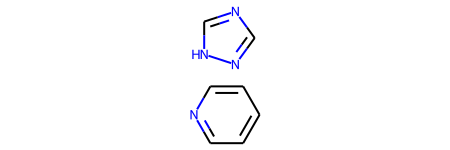

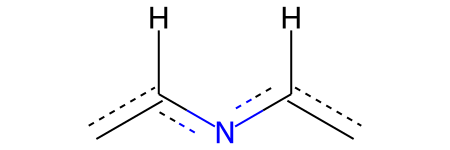

In [543]:
Chem.MolFromSmiles('c1ccncc1.c1nc[nH]n1')
Chem.MolFromSmarts('[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]')

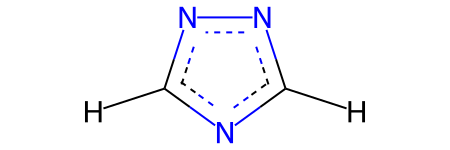

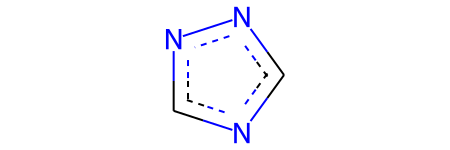

In [544]:
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1')

In [406]:
getCarrierFrags('c1nc[nH]n1',6)
Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]'))
moltest=Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.SanitizeMol(moltest)
moltest.UpdatePropertyCache(strict=False)
Chem.MolToSmiles(moltest,allHsExplicit=False)
Chem.MolToSmiles(Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1'))

['[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]',
 '[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]']

'[H]C1:N:N:C([H]):N:1'

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

'[H]C1:N:N:C([H]):N:1'

'C1:N:C:N:N:1'

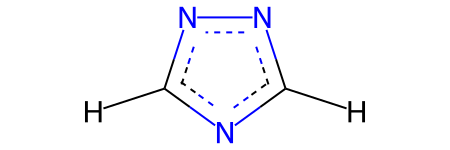

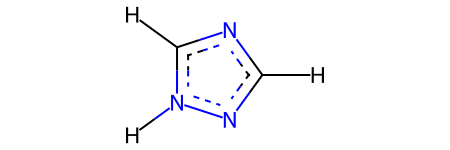

In [551]:
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]')

In [552]:
Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]'))

'[H]C1:N:C([H]):N([H]):N:1'

In [553]:
Chem.MolFromSmiles('[H]C1:N:C([H]):N([H]):N:1')

RDKit ERROR: [06:12:23] Explicit valence for atom # 3 N, 4, is greater than permitted


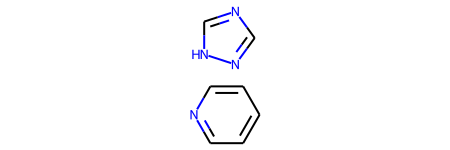

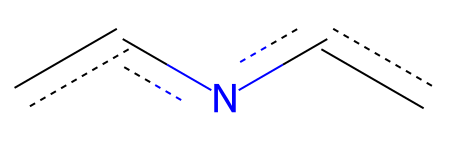

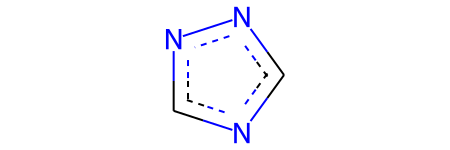

RDKit ERROR: [04:37:46] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [04:37:46] Explicit valence for atom # 3 N, 4, is greater than permitted


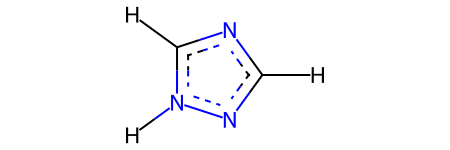

RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 190 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2020.09.1
	BOOST: 1_74


In [532]:
Chem.MolFromSmiles('c1ccncc1.c1nc[nH]n1')
Chem.MolFromSmiles('[H]C(:C):N:C([H]):C')
Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1')
Chem.MolFromSmiles('[H]C1:N:C([H]):N([H]):N:1')
Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]'),allHsExplicit=True))
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]')

In [535]:
Chem.MolToSmarts(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]'))

'[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[#1])-[#1]'

In [534]:
Chem.MolToSmarts(Chem.MolFromSmiles('c1nc[nH]n1'))

'[#6]1:[#7]:[#6]:[#7H]:[#7]:1'

In [536]:
getCarrierFrags('c1nc[nH]n1',0,resFormat='smarts')

['[#7]', '[#7]:[#7]']

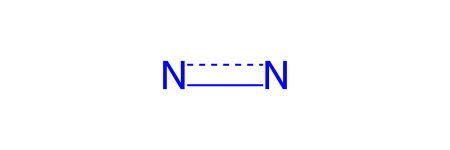

In [539]:
Chem.MolFromSmarts('[#7]:[#7]')

In [540]:
Chem.MolFromSmiles('[H]c1nc([H])n([H])n1')

In [139]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

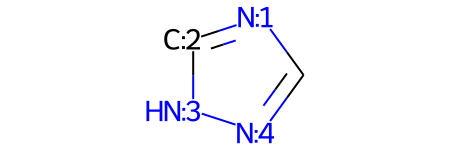

In [9]:
testmol=Chem.MolFromSmiles('c1nc[nH]n1')
Chem.SanitizeMol(testmol)
testmol.UpdatePropertyCache(strict=False)
Chem.AddHs(testmol)
mol_with_atom_index(testmol)


In [548]:
IFG(testmol)
testmol.GetAtomWithIdx(1)

[IFG(atomIds=(1,), atoms='n', type='cnc'),
 IFG(atomIds=(3, 4), atoms='n[nH]', type='cn[nH]c')]

In [465]:
testdb2.set_index(['SubstanceID'],inplace=True)

In [468]:
testdb.set_index('SubstanceID',inplace=True)

In [464]:
testdb2.reset_index(inplace=True)

In [469]:
pd.concat([testdb,testdb2])

,FragmentSmiles,FragmentSmarts,Smiles,>1 Compound
SubstanceID,,,,
19243410,[H]C1:N:C([H]):N([H]):N:1,[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H],c1ccncc1.c1nc[nH]n1,True
19243410,[H]C(:C):N:C([H]):C,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],c1ccncc1.c1nc[nH]n1,True
19243410,[H]C1:N:N:C([H]):N:1,[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H],c1ccncc1.c1nc[nH]n1,True
16832508,B#N,[#5]#[#7],B#N.N.[LiH].[LiH].[LiH],True
16832508,N,[#7],B#N.N.[LiH].[LiH].[LiH],True
16832508,[LiH],[LiH],B#N.N.[LiH].[LiH].[LiH],True
16832508,[LiH],[LiH],B#N.N.[LiH].[LiH].[LiH],True
16832508,[LiH],[LiH],B#N.N.[LiH].[LiH].[LiH],True


In [460]:
pd.concat([testdb,testdb2]).drop([16832508],level=1)

,,FragmentSmarts,Smiles,>1 Compound
FragmentSmiles,SubstanceID,,,
[H]C1:N:C([H]):N([H]):N:1,19243410,[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H],c1ccncc1.c1nc[nH]n1,True
[H]C(:C):N:C([H]):C,19243410,[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],c1ccncc1.c1nc[nH]n1,True
[H]C1:N:N:C([H]):N:1,19243410,[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H],c1ccncc1.c1nc[nH]n1,True


In [462]:
CarrierFragmentDB4.index.unique()

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1249037, 1249038, 1249039, 1249040, 1249041, 1249042, 1249043,
            1249044, 1249045, 1249046],
           dtype='int64', length=1249047)

In [474]:
CarrierFragmentDB4.reset_index(inplace=True)

In [488]:
CarrierFragmentDB

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
0,[H]C([H])(C)OC(=O)C([H])([H])[H],925,[#6](-[#6](=[#8])-[#8]-[#6](-[#6])(-[H])-[H])(...,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1,False
1,[H]N(C)C(C)(C)N([H])C,925,[#6]-[#6](-[#6])(-[#7](-[#6])-[H])-[#7](-[#6])...,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1,False
2,[H]C([H])(C)OC(=O)C([H])([H])[H],925,[#6]-[#6](-[#8]-[#6](-[#6](-[H])(-[H])-[H])=[#...,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1,False
3,[H]C([H])(C)OC(=O)C([H])([H])C,929,[#6]-[#6](-[#6](=[#8])-[#8]-[#6](-[#6])(-[H])-...,CCCCCC(=O)OCC1(COC(=O)CCCCC)Nc2cccc3ccc(C4C(=O...,False
4,[H]N(C)C(C)(C)N([H])C,929,[#6]-[#6](-[#6])(-[#7](-[#6])-[H])-[#7](-[#6])...,CCCCCC(=O)OCC1(COC(=O)CCCCC)Nc2cccc3ccc(C4C(=O...,False
...,...,...,...,...,...
64549672,CO[Si](C)(C)C,32983885,[#6]-[#8]-[Si](-[#6])(-[#6])-[#6],C=C(CO[Si](C)(C)C(C)(C)C)[C@@H]1[C@@H]2CC[C@H]...,False
64549673,[H]C12CCC([H])(C1)C(=O)O2,32983885,[#6]1-[#6]2(-[#6]-[#6](-[#6]-1)(-[#6](=[#8])-[...,C=C(CO[Si](C)(C)C(C)(C)C)[C@@H]1[C@@H]2CC[C@H]...,False
64549674,[H]C(:C):C(Br):C([H]):C,32984157,[#35]-[#6](:[#6](:[#6])-[H]):[#6](:[#6])-[H],Brc1ccc2ncccc2c1.Cl,True
64549675,[H]Cl,32984157,[#17]-[H],Brc1ccc2ncccc2c1.Cl,True


In [609]:
CarrierFragmentDB4

,Smiles,FragmentSmiles,SubstanceID,FragmentSmarts,>1 Compound
0,B#N.N.[LiH].[LiH].[LiH],B#N,[16832508],[#5]#[#7],[True]
0,B#N.N.[LiH].[LiH].[LiH],N,[16832508],[#7],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]
0,B#N.N.[LiH].[LiH].[LiH],[LiH],[16832508],[LiH],[True]
...,...,...,...,...,...
1249045,c1ccc2cc(B(c3ccc4ccccc4c3)c3ccc4ccccc4c3)ccc2c...,C:C(:C)B(C(:C):C)C(:C):C,"[18851306, 18851306]",[#6]:[#6](-[#5](-[#6](:[#6]):[#6])-[#6](:[#6])...,"[True, True]"
1249045,c1ccc2cc(B(c3ccc4ccccc4c3)c3ccc4ccccc4c3)ccc2c...,[H]C(:C):N:C([H]):C,"[18851306, 18851306]",[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],"[True, True]"
1249046,c1ccncc1.c1nc[nH]n1,[H]C(:C):N:C([H]):C,"[19243410, 19243410, 19243410]",[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H],"[True, True, True]"
1249046,c1ccncc1.c1nc[nH]n1,[H]C1:N:N:C([H]):N:1,"[19243410, 19243410, 19243410]",[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H],"[True, True, True]"


In [331]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['SubstanceID']==31713109].compute()

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles,>1 Compound
61945111,C:C(:C)*C(:C):C,31713109,[#0](-[#6](:[#6]):[#6])-[#6](:[#6]):[#6],*(c1ccccc1)c1ccccc1.N.N.[1*].[1*],True
61945112,[H]N([H])[H],31713109,[#7](-[H])(-[H])-[H],*(c1ccccc1)c1ccccc1.N.N.[1*].[1*],True
61945113,[H]N([H])[H],31713109,[#7](-[H])(-[H])-[H],*(c1ccccc1)c1ccccc1.N.N.[1*].[1*],True
61945114,[1*],31713109,[1#0],*(c1ccccc1)c1ccccc1.N.N.[1*].[1*],True
61945115,[1*],31713109,[1#0],*(c1ccccc1)c1ccccc1.N.N.[1*].[1*],True


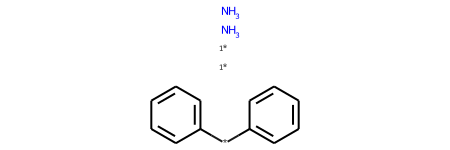

In [332]:
Chem.MolFromSmiles('*(c1ccccc1)c1ccccc1.N.N.[1*].[1*]')

In [361]:
CarrierFragmentDB3.loc[1239046]

Smiles                  [Cu].[Cu].[Cu].[Cu].[Er].[Er].[Er].[GaH3].[GaH...
FragmentSmiles  list    [[Cu].[Cu].[Cu].[Cu].[Er].[Er].[Er].[GaH3].[Ga...
SubstanceID     list                                 [22599583, 22599598]
FragmentSmarts  list    [[Cu], [Cu], [Cu], [Cu], [Er], [Er], [Er], [Ga...
>1 Compound     list                                         [True, True]
Name: 1239046, dtype: object

In [110]:
CarrierFragmentDB.rename(columns={'CarrierFragmentSmiles':'FragmentSmiles','CarrierFragmentSmarts':'FragmentSmarts'},inplace=True)

In [112]:
CarrierFragmentDBDask=CarrierFragmentDBDask.rename(columns={'CarrierFragmentSmiles':'FragmentSmiles','CarrierFragmentSmarts':'FragmentSmarts'})

In [114]:
CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [113]:
CarrierFragmentDBDask

,FragmentSmiles,SubstanceID,FragmentSmarts,Smiles
npartitions=181,,,,
0,object,int64,object,object
356629,...,...,...,...
...,...,...,...,...
64193220,...,...,...,...
64549676,...,...,...,...


In [100]:
res

['[#35]-[#6](:[#6](:[#6])-[H]):[#6](:[#6])-[H]',
 '[#6]:[#6](:[#7]:[#6](:[#6])-[H]):[#6]',
 '[#17]']

In [85]:
getCarrierFrags('Cl',6)

'[#17]'

In [81]:
getCarrierFrags('Brc1ccc2ncccc2c1',6)

['[#35]-[#6](:[#6](:[#6])-[H]):[#6](:[#6])-[H]',
 '[#6]:[#6](:[#7]:[#6](:[#6])-[H]):[#6]']

In [77]:
mol2=Chem.MolFromSmarts('[#17]')
Chem.SanitizeMol(mol2)
mol2.UpdatePropertyCache(strict=False)
Chem.MolToSmiles(mol2)
mol2.GetAtoms()[0].GetTotalNumHs()
Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolToSmiles(Chem.rdmolops.AddHs(mol2))))

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

'Cl'

1

'Cl'

In [79]:
Chem.MolToSmiles(Chem.rdmolops.AddHs(Chem.MolFromSmiles('Brc1ccc2ncccc2c1')))

'[H]c1nc2c([H])c([H])c(Br)c([H])c2c([H])c1[H]'

In [4]:
# -- directories for Reaxys data
# allrxtidsdir='/home/zg268/py2projects/reaction_1/AllRxtIDs.dat'
# This file contains reactant IDs in Reaxys
allrxtidsdir = '/home/aa2133/Impurity-Project/Reaxys_Data/AllRxtIDs.dat'
# rxnSource='/home/projects/graph/11step_network_774355/zg_good_data_noDupRXID2.dat'
# This file contains the reaction network
rxnSource = '/home/aa2133/Impurity-Project/Reaxys_Data/zg_good_data_noDupRXID2.dat'

# This is a directory containing all mol files
molfilesource = '/home/projects/graph/data/'

# Dask

In [4]:
from dask.distributed import Client, LocalCluster

In [5]:
cluster=LocalCluster(n_workers=16,threads_per_worker=2,scheduler_port=42117) # dashboard_address=':8786
client = Client(cluster) #'127.0.0.1:8786' is default scheduler cluster

In [39]:
client = Client('tcp://127.0.0.1:42117') #Use when scheduler already initiated

In [6]:
client

Client Scheduler: tcp://127.0.0.1:42117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 32 Memory: 67.51 GB


In [158]:
client.restart()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING 

Client Scheduler: tcp://127.0.0.1:42117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 32 Memory: 67.51 GB


In [594]:
cluster.close()
client.close()

# Cleaning Data

Below, the existing substance database is loaded as a pandas dataframe (pickle file) and processed(imputing missing values, defining column data types). Note that this takes up several gigabytes of space in memory but is nearly 10 times faster at retrieving indexed data (however, when doing intensive write/modifying operations on the entire database or non-indexed data slowdows will be expected due to inability to parallelize). For optimizing pandas, check https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6. Otherwise use pandas documentation: https://pandas.pydata.org/pandas-docs/stable/index.html

In [5]:
substancedb = openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB.pickle")

In [9]:
substancedb

,MolFileAddress,Smiles,Error
SubstanceID,,,
6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,No
27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,No
29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],No
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,No
9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,No
...,...,...,...
26761831,/home/projects/graph/data/batch_12600000/26761831,CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,No
3409746,/home/projects/graph/data/batch_12600000/3409746,N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,No
6138726,/home/projects/graph/data/batch_12600000/6138726,CN(O)C(CCC(C)(C)O)C1=CCCCC1,No


The error column has NaN values as there is no error in processing the molfile. Therefore, imputation is needed (filling in missing values) 

In [138]:
substancedb['Error'].fillna('No', inplace=True)
substancedb['Smiles'].fillna('Error', inplace=True)
substancedb.Error.unique()

array(['No', 'Valence error',
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 8 9 10 11 14 15 16 17 19 20 21 22 25 26 27 28 31 32 33 34 35 36 39 40 41 42 45 46 47 48 49 50 52 53 54 55 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27 28 29 30 31 34 36 37 38 39 40 41 42 43 44 45 49 50 53 54 55 56 57 58 59 63 64 68 69 72\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 46 47 48 49 50 51 52 53 54 55 59 60 65 66 67 68 69 70 71 72 73 77 80 81 82 83 84 92 93 94 96 101 102 107\n"),
       KekulizeException("Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

Some pandas functions are depicted below to test speed of retrieval

In [149]:
substancedb.loc[6138726]

substancedb.loc[substancedb['Smiles'] == 'COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1']

MolFileAddress    /home/projects/graph/data/batch_12600000/6138726
Smiles                                 CN(O)C(CCC(C)(C)O)C1=CCCCC1
Error                                                           No
Name: 6138726, dtype: object

,MolFileAddress,Smiles,Error
SubstanceID,,,
11404182,/home/projects/graph/data/batch_12600000/11404182,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,No


In [159]:
substancedb = substancedb.astype(
    {'MolFileAddress': 'str', 'Smiles': 'str', 'Error': 'str'})

In [161]:
substancedb.dtypes

MolFileAddress    object
Smiles            object
Error             object
dtype: object

In [162]:
substancedb.MolFileAddress.isnull().values.any()
substancedb.Smiles.isnull().values.any()
substancedb.Error.isnull().values.any()

False

False

False

The below indicates all entries where molfiles are unable to be processed. Around 1,281,117 compounds are not processable by RDKit, of which 1,281,041 is due to valence error and 76 are due to kekulization errors (related to lack of specification of hydrogens on rings). Most of these are massive compounds containing in excess of 40 carbons and 80 hydrogens.

In [170]:
substancedb[substancedb['Error'] != 'No'].count()
substancedb[substancedb['Error'] == 'Valence error'].count()

MolFileAddress    1281117
Smiles            1281117
Error             1281117
dtype: int64

MolFileAddress    1281041
Smiles            1281041
Error             1281041
dtype: int64

In [24]:
substancedb[(substancedb['Error'] != 'Valence error')
            & (substancedb['Error'] != 'No')]

,MolFileAddress,Smiles,Error
SubstanceID,,,
19341494,/home/projects/graph/data/batch_13900000/19341494,Error,Can't kekulize mol. Unkekulized atoms: 2 3 5 ...
28393675,/home/projects/graph/data/batch_12100000/28393675,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...
32700079,/home/projects/graph/data/batch_12100000/32700079,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...
9839520,/home/projects/graph/data/batch_8500000/9839520,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...
32439857,/home/projects/graph/data/batch_8600000/32439857,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...
...,...,...,...
23776736,/home/projects/graph/data/batch_8800000/23776736,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...
24038178,/home/projects/graph/data/batch_8800000/24038178,Error,Can't kekulize mol. Unkekulized atoms: 1 5 6 ...
31525914,/home/projects/graph/data/batch_8800000/31525914,Error,Can't kekulize mol. Unkekulized atoms: 0 1 2 ...


In [8]:
substancedb

,MolFileAddress,Smiles,Error
SubstanceID,,,
6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,No
27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,No
29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],No
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,No
9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,No
...,...,...,...
26761831,/home/projects/graph/data/batch_12600000/26761831,CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,No
3409746,/home/projects/graph/data/batch_12600000/3409746,N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,No
6138726,/home/projects/graph/data/batch_12600000/6138726,CN(O)C(CCC(C)(C)O)C1=CCCCC1,No


Next, the goal is to identify mixtures or reaxys compounds that contain multiple substances (eg. salts). This is useful in the future as retrieving carrier fragments will entail splitting of the smiles string.

In [ ]:
substancedbdask = dd.from_pandas(substancedb, npartitions=16)
substancedbdask = client.persist(substancedbdask)

In [11]:
mixturecol=substancedbdask.map_partitions(findMixturespartition,meta=('>1 Compound','boolean')).compute()
substancedb=joindf(pd.DataFrame(mixturecol),substancedb)
substancedb

,MolFileAddress,Smiles,Error,>1 Compound
SubstanceID,,,,
6890270,/home/projects/graph/data/batch_6500000/6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,No,False
27615522,/home/projects/graph/data/batch_6500000/27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,No,False
29164535,/home/projects/graph/data/batch_6500000/29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],No,True
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,No,False
9019791,/home/projects/graph/data/batch_6500000/9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,No,False
...,...,...,...,...
26761831,/home/projects/graph/data/batch_12600000/26761831,CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,No,False
3409746,/home/projects/graph/data/batch_12600000/3409746,N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,No,False
6138726,/home/projects/graph/data/batch_12600000/6138726,CN(O)C(CCC(C)(C)O)C1=CCCCC1,No,False


In [ ]:
substancedb.reset_index(inplace=True)
substancedb.set_index(['Smiles','SubstanceID'],inplace=True)

In [13]:
writepickle(substancedb, '/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB')

# Running fragment detection

## Building dask dataframe from cleaned substance database

The cells below build a dask dataframe with 16 partitions for faster parallel computation. It does not take up much memory in the server as a result, but is slower at reading/fetching indexed data. The final file is written to parquet (This has been deprecated as it takes too much memory. It is more advisable to generate a dask dataframe from pandas)

In [14]:
substancedbdask = dd.from_pandas(substancedb, npartitions=16)

In [15]:
substancedbdask = client.persist(substancedbdask)

In [176]:
# substancedbdask.to_parquet(
#     "/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDBDask")

## Loading dataframe and testing

In [212]:
# substancedbdask = dd.read_parquet(
#     "/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDBDask")

In [16]:
substancedbdask.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, MolFileAddress to >1 Compound
dtypes: object(4)

In [19]:
substancedbdask.get_partition(2)
substancedbdask.memory_usage_per_partition().compute()

,MolFileAddress,Smiles,Error,>1 Compound
npartitions=1,,,,
4594734,object,object,object,object
5872788,...,...,...,...


0     40323640
1     40323640
2     40323640
3     40323640
4     40323640
5     40323640
6     40323640
7     40323640
8     40323640
9     40323640
10    40323640
11    40323640
12    40323640
13    40323640
14    40323640
15    40323440
dtype: int64

In [20]:
substancedbdask.loc[2632386].compute()

substancedbdask.loc[substancedbdask['Smiles']
                    == 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'].compute()

,MolFileAddress,Smiles,Error,>1 Compound
SubstanceID,,,,
2632386,/home/projects/graph/data/batch_5700000/2632386,CCCCCCCCCCCCCCCCCCN(CC(C)(C)C=O)C(=O)c1ccccc1,No,False


,MolFileAddress,Smiles,Error,>1 Compound
SubstanceID,,,,
11230426,/home/projects/graph/data/batch_6500000/11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,No,False


In [21]:
substancedbdask.loc[2632386].compute()

,MolFileAddress,Smiles,Error,>1 Compound
SubstanceID,,,,
2632386,/home/projects/graph/data/batch_5700000/2632386,CCCCCCCCCCCCCCCCCCN(CC(C)(C)C=O)C(=O)c1ccccc1,No,False


In [243]:
g = substancedbdask.loc[2632386, 'Smiles'].compute()[2632386]
g

'CCCCCCCCCCCCCCCCCCN(CC(C)(C)C=O)C(=O)c1ccccc1'

In [245]:
f = substancedb.loc[2632386, 'Smiles']
f

'CCCCCCCCCCCCCCCCCCN(CC(C)(C)C=O)C(=O)c1ccccc1'

Now, the question remains whether it is best to build another column row by row or build a dataframe from an entire column. https://towardsdatascience.com/apply-function-to-pandas-dataframe-rows-76df74165ee4 has more details. Building an entire column, and appending this to the dataframe is better and has been implemented.

## Creating dask dataframe to house fragment data

Creating a new dataframe to house information on fragments. This is a subset of the substance database containing only substance IDs, Smiles and mixture identification where molfiles CAN be processed. The index is reset (as indexing is the same across all partitions ie. 1 to 1000000 for partition 1, 1 to 1000000 for partition2 and so on), and a dask dataframe (substancedbdask2) is generated. Totally 14.8 million compounds out of the original 16 million compounds can be processed this way.

In [8]:
fdbm=substancedb.reset_index()[['SubstanceID', 'Smiles','>1 Compound']]
fdbm=fdbm[fdbm.Smiles!='Error']
substancedbdask2=dd.from_pandas(fdbm,npartitions=16)
substancedbdask2=client.persist(substancedbdask2)

In [34]:
substancedbdask2['SubstanceID'].count().compute()

14848334

## Simple solution (Pandas)

The bottom section served to highlight how inefficient it is using pandas (single core)

In [523]:
testset = substancedbdask2.head(100000)

In [506]:
testset

,SubstanceID,Smiles
0,925,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1
1,929,CCCCCC(=O)OCC1(COC(=O)CCCCC)Nc2cccc3ccc(C4C(=O...
2,930,CC(C)(C)C(=O)OCC1(COC(=O)C(C)(C)C)Nc2cccc3ccc(...
3,931,O=C(OCC1(COC(=O)c2ccccc2)Nc2cccc3ccc(C4C(=O)C(...
4,932,CCCCCCCCCC(=O)OCC1(COC(=O)CCCCCCCCC)Nc2cccc3cc...
...,...,...
295,1329,IS1(I)CCOCC1
296,1330,Br[Te]1(Br)CCOCC1
297,1331,I[Te]1(I)CCOCC1
298,1332,OC[C@H]1OCCCC1O


In [504]:
applycol=testset.apply(getfrags,natoms=0,axis=1)

2.17 seconds per every 100 rows translates to {{2.17*(16000000/100)/3600}} hours

In [501]:
applycol

0      [[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]...
1      [[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]...
2      [[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]...
3      [[#8]=[#6]-[#8], [#6](-[#7])-[#7], [#8]-[#6]=[...
4      [[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]...
                             ...                        
195                                  [[#6]1-[#8]-[#6]-1]
196                                  [[#6]1-[#8]-[#6]-1]
197                                  [[#16], [#7], [#7]]
198                                               [[#7]]
199                                               [[#7]]
Length: 200, dtype: object

## Simple solution (parallel)

This employs dask. However, it is slower for smaller datasets. The get carrier frags function is applied to each partition in the modified substance database using all 16 cores for carrier fragments (n=6). Subsequently, fragment smiles are calculated by processing the fragment smarts. The reason for this is that there are many smarts representations of a fragment structure but only one canonical smiles, so filtering the database by canonical smiles can capture more analogue compounds. This workflow is first tested on a test set of 100 compounds to ensure everything work smoothly and then tested on the entire dataset. The results are stored in pickle files on the server

### Test set

In [99]:
dasktestset=dd.from_pandas(substancedbdask2.loc[:100].compute(),npartitions=16)
dasktestset=client.persist(dasktestset)

In [113]:
dasktestset.loc[dasktestset['>1 Compound']==True].compute()

,SubstanceID,Smiles,>1 Compound
2,29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
53,16828067,O=[N+]([O-])[O-].[H][N+]([H])([H])[H].[Np+4],True
60,18159874,[Ni].[SnH2],True
79,3715603,CCC(N)Cc1c[nH]c2ccccc12.Cl,True


In [143]:
applycolp2=dasktestset.map_partitions(getfragpartition,natoms=6,meta=('FragmentSmarts','O')).compute()
dasktestset=client.persist(dd.from_pandas(joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute()),npartitions=16)) 

In [144]:
applycolp3=dasktestset.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()

In [145]:
finaldb=joindf(pd.DataFrame(applycolp3),joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute()))

In [174]:
finaldb2=joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute())

In [176]:
finaldb2=finaldb2.explode('FragmentSmarts')

In [180]:
finaldb2.loc[finaldb2['FragmentSmarts']=='Error']

,SubstanceID,Smiles,>1 Compound,FragmentSmarts


In [179]:
pd.DataFrame(applycolp3).explode('FragmentSmiles')

,FragmentSmiles
0,[H]C([H])([H])C(F)(C([H])([H])C)C([H])(C)Br
0,[H]C([H])(C)C([H])(Br)C(C)(C)F
1,C:C(C):N:C(:C):C
1,[H]C(:C):C(F):C([H]):C
1,[H]C1([H])OC:CO1
...,...
100,[H]C(C)(O)N1:C(C):N:C:C:1:N
100,[H]N(:C):C(=O):C(:C):N
100,[H]C1(C)CCC([H])(N)O1
100,[H]N(:C(:N)N):C(:C)=O


In [146]:
finaldb.loc[1].FragmentSmarts
finaldb.loc[1].FragmentSmiles

['[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6]',
 '[#6]:[#6](:[#6](-[#9]):[#6](:[#6])-[H])-[H]',
 '[#6]1:[#6]-[#8]-[#6](-[#8]-1)(-[H])-[H]',
 '[#6]-[#6](:[#6]):[#6](:[#6](:[#6])-[H])-[#9]']

['C:C(C):N:C(:C):C',
 '[H]C(:C):C(F):C([H]):C',
 '[H]C1([H])OC:CO1',
 '[H]C(:C):C(F):C(:C)C']

In [133]:
finaldb.loc[1]

SubstanceID                                                27615522
Smiles                  Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F
>1 Compound                                                   False
FragmentSmarts    [[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6], [#6]:...
FragmentSmiles    [C:C(C):N:C(:C):C, [H]C(:C):C(F):C([H]):C, [H]...
Name: 1, dtype: object

Something to take note is that the fragment smarts should be used in substructure searches instead of fragment smiles, as it is often invalid/cannot generate a valid molecule due to valence errors.

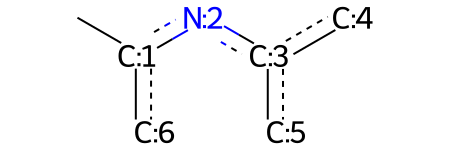

RDKit ERROR: [18:21:23] Explicit valence for atom # 4 C, 5, is greater than permitted


In [147]:
mol_with_atom_index(Chem.MolFromSmarts('[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6]'))
Chem.MolFromSmiles('C:C(C):N:C(:C):C')

In [171]:
testmol=Chem.MolFromSmiles('Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F')
testmol=Chem.AddHs(testmol)
patt=Chem.MolFromSmarts('[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6]')

In [172]:
testmol.GetSubstructMatches(patt)

((3, 4, 5, 6, 7, 12, 18),)

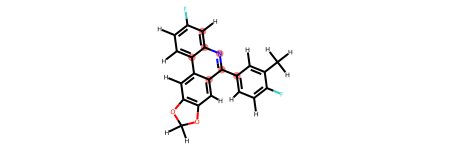

In [173]:
testmol

In [81]:
dasktestset.loc[0].compute()['Smiles'].values[0]

'CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1'

### Real dataset

In [ ]:
carrierfragsmarts=substancedbdask2.map_partitions(getfragpartition,natoms=6,meta=('FragmentSmarts','O')).compute()
carrierfragsmartsdf=pd.DataFrame(carrierfragsmarts)
writepickle(carrierfragsmartsdf,"/home/aa2133/Impurity-Project/Reaxys_Data/fragsmarts(n=6)")

substancedbdask2=client.persist(dd.from_pandas(joindf(carrierfragsmartsdf,fdbm),npartitions=16))
carrierfragsmiles=substancedbdask2.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()
carrierfragsmilesdf=pd.DataFrame(carrierfragsmiles)
writepickle(carrierfragsmilesdf,"/home/aa2133/Impurity-Project/Reaxys_Data/fragsmiles(n=6)")

In [10]:
carrierfragsmartsdf=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/fragsmarts(n=6).pickle")
carrierfragsmilesdf=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/fragsmiles(n=6).pickle")

We now have columns for fragment smarts and fragment smiles of each compound in the database, taking roughly 1.5 hours using 16 cores on the server. This is almost 100 times faster than just using a single core, which would take almost 3-4 days.

In [11]:
carrierfragsmartsdf
carrierfragsmilesdf

,FragmentSmarts
0,[[#6]-[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#9])...
1,"[[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6], [#6]:..."
2,"[[Gd+3], [Na+], [#8-]-[#5](-[#8-])-[#8-], [Tb+3]]"
3,"[[#7](-[#6](:[#6]):[#6])(-[H])-[H], [#6]:[#6](..."
4,"[[#6]-[#6](-[#8]-[#6](:[#6]):[#6])(-[H])-[H], ..."
...,...
16129446,[[#6]-[#6](-[#8]-[#6](=[#8])-[#6](-[#6])(-[#6]...
16129447,"[[#7]#[#6]-[#6](-[#6])(-[#8])-[H], [#6]-[#6](-..."
16129448,[[#6](-[#7](-[#8]-[H])-[#6](-[#6])(-[#6])-[H])...
16129449,"[[#6]:[#7](:[#6])-[#6](=[#8])-[#8-], [Li+]]"


,FragmentSmiles
0,"[[H]C([H])([H])C(F)(C([H])([H])C)C([H])(C)Br, ..."
1,"[C:C(C):N:C(:C):C, [H]C(:C):C(F):C([H]):C, [H]..."
2,"[[Gd+3], [Na+], [O-]B([O-])[O-], [Tb+3]]"
3,"[[H]N([H])C(:C):C, [H]C(:C):C(F):C(:C)N, [H]C1..."
4,"[[H]C([H])(C)OC(:C):C, CC1:C:N:C(C):N:1, [H]C(..."
...,...
16129446,"[[H]C([H])(C)OC(=O)C(C)(C)P, COP(C)(=O)OC]"
16129447,"[[H]C(C)(O)C#N, [H]C([H])(C)OC(=O)C(:C):C, [H]..."
16129448,"[[H]ON(C([H])([H])[H])C([H])(C)C, [H]OC(C)(C)C..."
16129449,"[C:N(:C)C(=O)[O-], [Li+]]"


In [193]:
substancedbdask2.memory_usage(deep=True).compute()

>1 Compound        481083300
FragmentSmarts    1668926622
Index              118786672
Smiles            1643552196
SubstanceID        118786672
dtype: int64

Restarting workers after computation will free up memory

In [195]:
client.restart()

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nann

Client Scheduler: tcp://127.0.0.1:42117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 32 Memory: 67.51 GB


# Assembling final dataframe

In [16]:
fdbm

,SubstanceID,Smiles,>1 Compound
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
2,29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
3,11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,False
4,9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
...,...,...,...
16129446,26761831,CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,False
16129447,3409746,N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,False
16129448,6138726,CN(O)C(CCC(C)(C)O)C1=CCCCC1,False
16129449,22727365,CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O...,True


Now that we have all the columns we intend to add, we can merge the fragment smarts and fragment smiles columns (exploded so each column is a new fragment), and merge the combined dataframe with the master database (fdbm). The index is set to a multiindex, containing fragment smiles and substance ID.  Keep in mind that if generating a dask dataframe from this, the index needs to be reset as dask is not compatible with multiindex. The final file is writted to disk. A test is done on 20 rows and then replicated for the entire dataset. It is hard to reshuffle data in the final database due to its size (68 million rows) or implode it back to a list form. There may be a better way to handle such large datasets (SQL for instance, but on trying this, the disk space is massive due to metadata >18 gb).

In [27]:
fdbmlite=fdbm.loc[:20]

In [28]:
fdbmlite
cfsmartslite=carrierfragsmartsdf.loc[:20]
cfsmileslite=carrierfragsmilesdf.loc[:20]

,SubstanceID,Smiles,>1 Compound
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False
2,29164535,[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],True
3,11230426,Nc1cc(F)c(N2CC(F)C2)c(F)c1,False
4,9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,False
5,4584084,CC(C)(C)OC(=O)C=C1C[N+]([O-])=C(c2ccccc2F)c2cc...,False
6,918811,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1NN,False
7,11185773,Cc1ccccc1CCCCCCC(=O)c1ncc(-c2ccccn2)o1,False
8,6156831,CCOC(=O)c1c(-c2cccc([N+](=O)[O-])c2)cc(-c2cccc...,False
9,9633035,CCCCCCc1cc(C)ccc1Sc1ccccc1,False


In [45]:
cfsmarts=cfsmartslite.explode('FragmentSmarts')
cfsmarts['FragmentSmiles']=cfsmileslite.explode('FragmentSmiles')
joindf(cfsmarts,fdbmlite)

,SubstanceID,Smiles,>1 Compound,FragmentSmarts,FragmentSmiles
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False,[#6]-[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#9])-...,[H]C([H])([H])C(F)(C([H])([H])C)C([H])(C)Br
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False,[#6]-[#6](-[#6])(-[#9])-[#6](-[#35])(-[#6](-[#...,[H]C([H])(C)C([H])(Br)C(C)(C)F
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6],C:C(C):N:C(:C):C
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]:[#6](:[#6](-[#9]):[#6](:[#6])-[H])-[H],[H]C(:C):C(F):C([H]):C
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]1:[#6]-[#8]-[#6](-[#8]-1)(-[H])-[H],[H]C1([H])OC:CO1
...,...,...,...,...,...
17,1079085,CC1=NS(=O)(=O)c2cc(Br)cc(Br)c2N1,False,[#6](=[#7]-[#16](=[#8])=[#8])-[#7],NC=N[SH](=O)=O
17,1079085,CC1=NS(=O)(=O)c2cc(Br)cc(Br)c2N1,False,[#6]:[#6](:[#6](-[#35]):[#6](:[#6])-[H])-[H],[H]C(:C):C(Br):C([H]):C
17,1079085,CC1=NS(=O)(=O)c2cc(Br)cc(Br)c2N1,False,[#6]:[#6](:[#6](:[#6](:[#6])-[H])-[#35])-[#7],[H]C(:C):C(Br):C(:C)N
18,23608115,CCc1ccc(C#CC(C)(C)C#N)cc1,False,[#6]-[#6](-[#6])(-[#6])-[#6]#[#7],CC(C)(C)C#N


In [40]:
carrierfragsmartsdf=carrierfragsmartsdf.explode('FragmentSmarts')
carrierfragsmartsdf['FragmentSmiles']=carrierfragsmilesdf.explode('FragmentSmiles')

In [41]:
carrierfragsmartsdf

,FragmentSmarts,FragmentSmiles
0,[#6]-[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#9])-...,[H]C([H])([H])C(F)(C([H])([H])C)C([H])(C)Br
0,[#6]-[#6](-[#6])(-[#9])-[#6](-[#35])(-[#6](-[#...,[H]C([H])(C)C([H])(Br)C(C)(C)F
1,[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6],C:C(C):N:C(:C):C
1,[#6]:[#6](:[#6](-[#9]):[#6](:[#6])-[H])-[H],[H]C(:C):C(F):C([H]):C
1,[#6]1:[#6]-[#8]-[#6](-[#8]-1)(-[H])-[H],[H]C1([H])OC:CO1
...,...,...
16129450,[#6]:[#6](-[#6](-[#17])(-[H])-[H]):[#6],[H]C([H])(Cl)C(:C):C
16129450,[#6]:[#6](:[#6])-[#8]-[#6](-[#6])(-[H])-[H],[H]C([H])(C)OC(:C):C
16129450,[#6]:[#6](-[#6](-[#9])(-[#9])-[#9]):[#6],C:C(:C)C(F)(F)F
16129450,[#6]:[#6](-[#6](-[#9])(-[#9])-[#9]):[#6],C:C(:C)C(F)(F)F


In [49]:
fdbm.drop('FragmentSmarts',axis=1,inplace=True) #Option (to clean dataframe if excess columns are already there)

In [51]:
fdbm=joindf(carrierfragsmartsdf,fdbm)

In [52]:
fdbm

,SubstanceID,Smiles,>1 Compound,FragmentSmarts,FragmentSmiles
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False,[#6]-[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#9])-...,[H]C([H])([H])C(F)(C([H])([H])C)C([H])(C)Br
0,6890270,CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,False,[#6]-[#6](-[#6])(-[#9])-[#6](-[#35])(-[#6](-[#...,[H]C([H])(C)C([H])(Br)C(C)(C)F
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6],C:C(C):N:C(:C):C
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]:[#6](:[#6](-[#9]):[#6](:[#6])-[H])-[H],[H]C(:C):C(F):C([H]):C
1,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,False,[#6]1:[#6]-[#8]-[#6](-[#8]-1)(-[H])-[H],[H]C1([H])OC:CO1
...,...,...,...,...,...
16129450,11404182,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False,[#6]:[#6](-[#6](-[#17])(-[H])-[H]):[#6],[H]C([H])(Cl)C(:C):C
16129450,11404182,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False,[#6]:[#6](:[#6])-[#8]-[#6](-[#6])(-[H])-[H],[H]C([H])(C)OC(:C):C
16129450,11404182,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False,[#6]:[#6](-[#6](-[#9])(-[#9])-[#9]):[#6],C:C(:C)C(F)(F)F
16129450,11404182,COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1,False,[#6]:[#6](-[#6](-[#9])(-[#9])-[#9]):[#6],C:C(:C)C(F)(F)F


In [54]:
fdbm.index

Int64Index([       0,        0,        1,        1,        1,        1,
                   2,        2,        2,        2,
            ...
            16129448, 16129448, 16129449, 16129449, 16129450, 16129450,
            16129450, 16129450, 16129450, 16129450],
           dtype='int64', length=68233617)

In [55]:
fdbm.set_index(['FragmentSmiles','SubstanceID'],inplace=True)

In [56]:
writepickle(fdbm,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6)')

The entire above workflow (Section 4) has been condensed into a function, `buildfragmentdb`in Section 1. Applying this function to generate the active fragment (n = 0) database

In [285]:
buildfragdb(fdbm=testset,fragseries=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/cf_res.pickle"),pfdb=True,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragment(n=6)DB")

Unindexed fragment database completed


In [302]:
buildfragdb(fdb=ActiveFragmentDB,dfdb=True,writedfdb='/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDBDask')

Dask fragment database created
Dask fragment database written to file: /home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDBDask


In [303]:
buildfragdb(fdb=CarrierFragmentDB,dfdb=True,writedfdb='/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

Dask fragment database created
Dask fragment database written to file: /home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)


In [10]:
buildfragdb(fdb=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB.pickle"),pfdb=True,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB")

Pandas fragment database created
Pandas fragment database written to file: /home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB


In [58]:
buildfragdb(fdb=CarrierFragmentDB,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6)")

Pandas fragment database written to file: /home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6)


# Testing and cleaning

The main takeaways here are that the dask dataframe is faster on multiple tries after persisting than pandas version due to more cores able to search. Also, it is more amenable for intensive parallel computation that requires processing of each row. However, it is far more memory intensive, takes up more space (by a factor of 8 times in some cases) on disk and does not support multi-indexing. 

As the dask database is likely to be grouped by fragment it makes the most sense to apply it as an index (keeping in mind that creating a dask dataframe needs to be done by resetting the index or setting substance id as an index). *This is difficult, as the kernel keeps dying for some reason. For now, substance ID is kept as the index.*

For the pandas dataframe, multindexing by fragment and substance ID is most effective both in reducing disk space of the database, and speed of access. If the database can be loaded to memory, pandas is preferable (Takes roughly 1.5 minutes to load).

## Carrier Fragment Database (n=6)

### Dask dataframe

In [106]:
CarrierFragmentDBDask=dd.read_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [72]:
CarrierFragmentDB.set_index('SubstanceID',inplace=True)

In [107]:
CarrierFragmentDBDask=dd.from_pandas(CarrierFragmentDB,npartitions=181)

# CarrierFragmentDBDask=CarrierFragmentDBDask.repartition(partition_size=100000000)

CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [86]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]'].compute()

,CarrierFragments,Smiles
SubstanceID,,
1619,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1cn[nH]c1
2611,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2ccsc2c1
2798,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2ccncc2c1
3216,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2cn[nH]c2c1
3255,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2[nH]cnc2c1
...,...,...
32937424,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1c(Cl)cc(Cl)cc1Cl.O=S(=O)(O)C(F)(F)F
32937425,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl.O=S(=O)(O)C(F)(F)F
32948348,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccccc1C(=O)Nc1cccc(O)c1


In [87]:
CarrierFragmentDBDask.to_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [100]:
CarrierFragmentDB2=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6).pickle')

In [88]:
writepickle(CarrierFragmentDBDask,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [65]:
demoset=CarrierFragmentDBDask.loc['[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]'].compute()

In [35]:
demoset=CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]'].compute()

In [73]:
demoset['SubstanceID']

CarrierFragments
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    17837695
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    19237993
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]     2296867
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]     6588066
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]     6588035
                                            ...   
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    28511182
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    28511183
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]     2167649
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    10725424
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]    28511177
Name: SubstanceID, Length: 252, dtype: int64

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


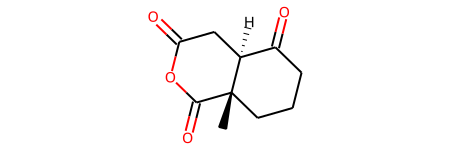

In [45]:
Chem.MolFromSmiles(demoset.loc[11305,'Smiles'])

In [176]:
CarrierFragmentDBDask2.loc['Error'].compute()

,SubstanceID,Smiles
CarrierFragments,,
Error,71120,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
Error,17645627,CN(C)Cc1ccccc1[GeH2-](c1ccccc1CN(C)C)c1ccccc1C...
Error,17646942,COc1ccc(C)cc1[GeH2-](c1cc(C)ccc1OC)c1cc(C)ccc1...
Error,17662746,C1COCCO1.[Yb+2].c1ccc([GeH2-](c2ccccc2)c2ccccc...
Error,17666188,[K+].c1ccc2c(c1)[GeH4-2]c1ccccc1-2
...,...,...
Error,16866207,Cl[GeH2-](Cl)Cl.[Cs+]
Error,16865567,Cc1ccc(P(c2ccc(C)cc2)c2ccc(C)cc2)cc1.[Ag]12345...
Error,17104550,COCCOC.[Ag+].c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1c...


In [175]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='Error'].compute()

,CarrierFragments,Smiles
SubstanceID,,
71120,Error,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
2020777,Error,c1=c\c2ccc(c3ccccc23)/c=c\c2ccc(cc2)/c=c\c2ccc...
2566174,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c\c2ccccc2/c=c\...
2566175,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c/c2ccccc2/c=c\...
2642603,Error,c1=c\c2ccc(cc2)-c2ccccc2-c2ccc/1cc2
...,...,...
32826420,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826421,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826422,Error,CN(C)CCN(C)C.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[S...


In [168]:
CarrierFragmentDBDask.loc[71120:73000].compute()

,CarrierFragments,Smiles
SubstanceID,,
71120,Error,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
71121,[#7](-[#6](:[#6]):[#7])(-[H])-[H],Nc1c(C(=O)O)nnn1-c1ccc(S(=O)(=O)c2ccc(-n3nnc(C...
71121,[#6]:[#6](-[#6](=[#8])-[#8]-[H]):[#7],Nc1c(C(=O)O)nnn1-c1ccc(S(=O)(=O)c2ccc(-n3nnc(C...
71121,[#6]1:[#6]:[#7]:[#7]:[#7]:1-[#6],Nc1c(C(=O)O)nnn1-c1ccc(S(=O)(=O)c2ccc(-n3nnc(C...
71121,[#6]:[#6](-[#16](=[#8])(=[#8])-[#6](:[#6]):[#6...,Nc1c(C(=O)O)nnn1-c1ccc(S(=O)(=O)c2ccc(-n3nnc(C...
...,...,...
72999,[#6]1(-[#6]):[#7]:[#6](:[#6]):[#6]:[#7]:1,CC(=O)OC[C@@H](OC(C)=O)[C@H](OC(C)=O)[C@H](OC(...
72999,[#6]:[#7](:[#6])-[#6](-[#6])=[#8],CC(=O)OC[C@@H](OC(C)=O)[C@H](OC(C)=O)[C@H](OC(...
73000,[#6]-[#6](-[#8]-[#6](=[#8])-[#6](:[#6]):[#6])(...,C[C@H]1CC[C@@H]2[C@@H](C)[C@H]3[C@H](C[C@H]4[C...


In [32]:
CarrierFragmentDBDask.known_divisions

True

### Pandas dataframe

In [15]:
CarrierFragmentDB=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6).pickle")

In [16]:
CarrierFragmentDB.reset_index(inplace=True)

In [26]:
CarrierFragmentDBDask=CarrierFragmentDBDask.rename(columns={'CarrierFragments':'CarrierFragmentSmarts'})

In [32]:
CarrierFragmentDBDask

,CarrierFragmentSmarts,SubstanceID,Smiles
npartitions=181,,,
0,object,int64,object
356629,...,...,...
...,...,...,...
64193220,...,...,...
64549676,...,...,...


For information on meta types see https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/. For how to use it on dask, see make_meta under dask dataframe API

In [182]:
help(np.dtype)

Help on class dtype in module numpy:

class dtype(builtins.object)
 |  dtype(obj, align=False, copy=False)
 |  
 |  Create a data type object.
 |  
 |  A numpy array is homogeneous, and contains elements described by a
 |  dtype object. A dtype object can be constructed from different
 |  combinations of fundamental numeric types.
 |  
 |  Parameters
 |  ----------
 |  obj
 |      Object to be converted to a data type object.
 |  align : bool, optional
 |      Add padding to the fields to match what a C compiler would output
 |      for a similar C-struct. Can be ``True`` only if `obj` is a dictionary
 |      or a comma-separated string. If a struct dtype is being created,
 |      this also sets a sticky alignment flag ``isalignedstruct``.
 |  copy : bool, optional
 |      Make a new copy of the data-type object. If ``False``, the result
 |      may just be a reference to a built-in data-type object.
 |  
 |  See also
 |  --------
 |  result_type
 |  
 |  Examples
 |  --------
 |  Usin

In [37]:
smiles=CarrierFragmentDBDask.map_partitions(getsmilespartition,meta=('CarrierFragmentSmiles','O')).compute()

In [39]:
smilesdf=pd.DataFrame(smiles)

In [41]:
CarrierFragmentDB=CarrierFragmentDB.join(smilesdf)

In [43]:
CarrierFragmentDB.rename(columns={'CarrierFragments':'CarrierFragmentSmarts'},inplace=True)

In [48]:
CarrierFragmentDB.set_index(['CarrierFragmentSmiles','SubstanceID'],inplace=True)

In [49]:
CarrierFragmentDB.index

MultiIndex([('[H]C([H])(C)OC(=O)C([H])([H])[H]',      925),
            (           '[H]N(C)C(C)(C)N([H])C',      925),
            ('[H]C([H])(C)OC(=O)C([H])([H])[H]',      925),
            (  '[H]C([H])(C)OC(=O)C([H])([H])C',      929),
            (           '[H]N(C)C(C)(C)N([H])C',      929),
            (  '[H]C([H])(C)OC(=O)C([H])([H])C',      929),
            (          '[H]C1(C)CC([H])(C)C1=O',      929),
            (           '[H]N(C)C(C)(C)N([H])C',      929),
            (  '[H]C([H])(C)OC(=O)C([H])([H])C',      929),
            (  '[H]C([H])(C)OC(=O)C([H])([H])C',      929),
            ...
            (                 '[H]C([H])=C(C)C', 32983884),
            (                   'CO[Si](C)(C)C', 32983884),
            (        'C:C(:C)S(=O)(=O)C(C)(C)C', 32983884),
            (         '[H]C12CCC(S)(C1)C(=O)O2', 32983884),
            (                 '[H]C([H])=C(C)C', 32983885),
            (                   'CO[Si](C)(C)C', 32983885),
            (       '[H]

In [50]:
CarrierFragmentDB.loc['Error']

,CarrierFragmentSmarts,Smiles
SubstanceID,,
71120,Error,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
2020777,Error,c1=c\c2ccc(c3ccccc23)/c=c\c2ccc(cc2)/c=c\c2ccc...
2566174,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c\c2ccccc2/c=c\...
2566175,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c/c2ccccc2/c=c\...
2642603,Error,c1=c\c2ccc(cc2)-c2ccccc2-c2ccc/1cc2
...,...,...
32826420,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826421,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826422,Error,CN(C)CCN(C)C.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[S...


.xs is used for multiindexed dataframes

In [51]:
CarrierFragmentDB.xs('Error')

,CarrierFragmentSmarts,Smiles
SubstanceID,,
71120,Error,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
2020777,Error,c1=c\c2ccc(c3ccccc23)/c=c\c2ccc(cc2)/c=c\c2ccc...
2566174,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c\c2ccccc2/c=c\...
2566175,Error,c1=c\c2ccccc2/c=c\c2ccc(cc2)/c=c/c2ccccc2/c=c\...
2642603,Error,c1=c\c2ccc(cc2)-c2ccccc2-c2ccc/1cc2
...,...,...
32826420,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826421,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826422,Error,CN(C)CCN(C)C.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[S...


In [51]:
test1=CarrierFragmentDB.xs('[#7](-[#6](:[#6]):[#6])(-[H])-[H]').index

In [52]:
test2=CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]'].index.compute()

In [69]:
CarrierFragmentDBDask.index.compute()

Int64Index([     925,      925,      925,      929,      929,      929,
                 929,      929,      929,      929,
            ...
            32983884, 32983884, 32983884, 32983884, 32983885, 32983885,
            32983885, 32984157, 32984157, 32984157],
           dtype='int64', name='SubstanceID', length=63204892)

In [9]:
# CarrierFragmentDB.xs(294913,level=1)
CarrierFragmentDB.xs(4502,level=1)

,CarrierFragmentSmarts,Smiles
CarrierFragmentSmiles,,
[H]N([H])C(:C):C,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc2ncccc2c1N
[H]N([H])C(:C):C,[#6]:[#6](:[#6])-[#7](-[H])-[H],Nc1ccc2ncccc2c1N
[H]C(:C):N:C(:C):C,[#6]:[#6](:[#7]:[#6](:[#6])-[H]):[#6],Nc1ccc2ncccc2c1N


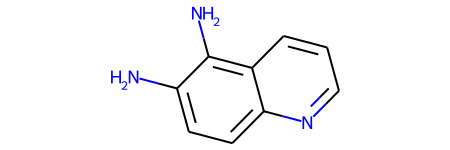

In [10]:
Chem.MolFromSmiles('Nc1ccc2ncccc2c1N')

In [53]:
CarrierFragmentDB.xs('[H]N([H])C(:C):C')

,CarrierFragmentSmarts,Smiles
SubstanceID,,
1619,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1cn[nH]c1
1727,[#6]:[#6](-[#7](-[H])-[H]):[#6],Cc1cc(N)c(C)o1
1848,[#6]:[#6](:[#6])-[#7](-[H])-[H],Cc1n[nH]cc1N
2364,[#6]:[#6](:[#6])-[#7](-[H])-[H],Cc1[nH]nc(Cl)c1N
2365,[#6]:[#6](:[#6])-[#7](-[H])-[H],Cc1n[nH]c(N)c1N
...,...,...
32972771,[#7](-[#6](:[#6]):[#6])(-[H])-[H],Nc1ccc(Br)cc1C#CCCCCO
32972772,[#6]:[#6](-[#7](-[H])-[H]):[#6],Cc1ccc(N)c(C#CCCCCO)c1
32972777,[#6]:[#6](-[#7](-[H])-[H]):[#6],COC(=O)c1ccc(N)c(C#CCCCCO)c1


In [54]:
CarrierFragmentDB.loc[CarrierFragmentDB['CarrierFragmentSmarts']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]']

CarrierFragmentSmarts  \
CarrierFragmentSmiles SubstanceID                                      
[H]N([H])C(:C):C      1619         [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      2611         [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      2798         [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      3216         [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      3255         [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
...                                                              ...   
                      32937424     [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      32937425     [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      32948348     [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      32964649     [#7](-[#6](:[#6]):[#6])(-[H])-[H]   
                      32972771     [#7](-[#6](:[#6]):[#6])(-[H])-[H]   

                                                                              Smiles  
CarrierFragmentSmiles SubstanceID                                                     
[H]N([H])C(:C):C      1619                                               Nc1cn[nH]c1  
                      2611                                            Nc1ccc2ccsc2c1  
                      2798                                           Nc1ccc2ccncc2c1  
                      3216                                         Nc1ccc2cn[nH]c2c1  
                      3255                                         Nc1ccc2[nH]cnc2c1  
...                                                                              ...  
                      32937424                Nc1c(Cl)cc(Cl)cc1Cl.O=S(=O)(O)C(F)(F)F  
                      32937425        Nc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl.O=S(=O)(O)C(F)(F)F  
                      32948348                            Nc1ccccc1C(=O)Nc1cccc(O)c1  
                      32964649     Nc1cccc([S-]2[Fe+]3(N=O)(N=O)[S-](c4cccc(N)c4)...  
                      32972771                                 Nc1ccc(Br)cc1C#CCCCCO  

[74582 rows x 2 columns]

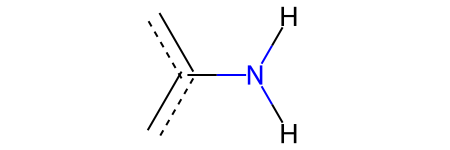

In [16]:
Chem.MolFromSmarts('[#7](-[#6](:[#6]):[#6])(-[H])-[H]')

In [116]:
CarrierFragmentDB.xs('[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]')

,Smiles
SubstanceID,
11305,C[C@]12CCCC(=O)[C@@H]1CC(=O)OC2=O
23173,CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1
34381,C[C@]12CC[C@H]3[C@@H](CC[C@H]4CC=CC[C@@]43C)[C...
36991,C[C@]12CC[C@H]3[C@@H](CC=C4C=CCC[C@@]43C)[C@@H...
38367,CC(=O)O[C@@H]1CC[C@]23C[C@@]1(C)CC[C@H]2C(C)(C...
...,...
32467478,CC(=O)Nc1sc(-c2ccc(C(=O)OC(C)=O)cc2)c(-c2cccc(...
32537675,CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
32537675,CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...


In [21]:
CarrierFragmentDB.xs(11305,level=1,drop_level=False)
CarrierFragmentDB.xs('[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]',drop_level=False)

,,Smiles
CarrierFragments,SubstanceID,
[#6]-[#6](-[#6](=[#8])-[#6](-[#6])(-[#6])-[H])(-[H])-[H],11305,C[C@]12CCCC(=O)[C@@H]1CC(=O)OC2=O
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],11305,C[C@]12CCCC(=O)[C@@H]1CC(=O)OC2=O


Smiles
CarrierFragments                       SubstanceID                                                   
[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8] 11305                        C[C@]12CCCC(=O)[C@@H]1CC(=O)OC2=O
                                       23173                        CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1
                                       34381        C[C@]12CC[C@H]3[C@@H](CC[C@H]4CC=CC[C@@]43C)[C...
                                       36991        C[C@]12CC[C@H]3[C@@H](CC=C4C=CCC[C@@]43C)[C@@H...
                                       38367        CC(=O)O[C@@H]1CC[C@]23C[C@@]1(C)CC[C@H]2C(C)(C...
...                                                                                               ...
                                       32467478     CC(=O)Nc1sc(-c2ccc(C(=O)OC(C)=O)cc2)c(-c2cccc(...
                                       32537675     CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
                                       32537675     CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
                                       32537675     CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
                                       32570467                                         CC(=O)OC(C)=O

[252 rows x 1 columns]

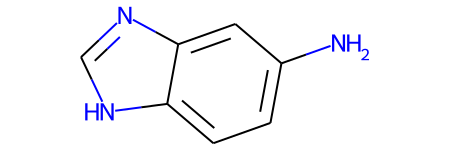

In [20]:
Chem.MolFromSmiles('Nc1ccc2[nH]cnc2c1')

### SQL Database

Very slow write speed (>15 mins for 65 million rows). Only benefit is compatibility outside python, and reading from disk due to memory constraints. It is interestingly quite fast (1 second), and at most half a minute. See https://pandas.pydata.org/pandas-docs/version/0.15.0/io.html#sql-queries. Obviously it cannot compare to in-memory pandas which when indexed properly takes less than a second. However, this could be useful in cases where memory is scarce or the database is far too large to load in memory. 

In [10]:
import sqlite3
import os

In [7]:
CarrierFragmentDB.reset_index(inplace=True)

In [22]:
db2=sqlite3.connect("/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db")

In [14]:
CarrierFragmentDB.set_index('CarrierFragments',inplace=True)

In [16]:
CarrierFragmentDB.to_sql("CarrierFragment(n=6)",db,if_exists="replace")

In [76]:
cursor = db2.cursor()
df = pd.read_sql_query('''select * from [CarrierFragment(n=6)]''', db2)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64549677 entries, 0 to 64549676
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   CarrierFragments  object
 1   SubstanceID       int64 
 2   Smiles            object
dtypes: int64(1), object(2)
memory usage: 1.4+ GB


In [29]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table_name in tables:
    table_name = table_name[0]

In [70]:
cursor.execute('''CREATE INDEX CarrierFragments ON [CarrierFragment(n=6)] (CarrierFragments);''')

In [71]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where CarrierFragments="[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]"''',db2)

,CarrierFragments,SubstanceID,Smiles
0,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],11305,C[C@]12CCCC(=O)[C@@H]1CC(=O)OC2=O
1,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],23173,CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1
2,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],34381,C[C@]12CC[C@H]3[C@@H](CC[C@H]4CC=CC[C@@]43C)[C...
3,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],36991,C[C@]12CC[C@H]3[C@@H](CC=C4C=CCC[C@@]43C)[C@@H...
4,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],38367,CC(=O)O[C@@H]1CC[C@]23C[C@@]1(C)CC[C@H]2C(C)(C...
...,...,...,...
247,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],32467478,CC(=O)Nc1sc(-c2ccc(C(=O)OC(C)=O)cc2)c(-c2cccc(...
248,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],32537675,CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
249,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],32537675,CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...
250,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],32537675,CC(=O)OC(=O)CN(CCN(CC(=O)OC(C)=O)CC(=O)OC(C)=O...


In [72]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where Smiles="CC(=O)Nc1ccc(O)cc1"''',db2)

,CarrierFragments,SubstanceID,Smiles
0,[#6]:[#6](:[#6](-[#8]-[H]):[#6](:[#6])-[H])-[H],2208089,CC(=O)Nc1ccc(O)cc1
1,[#6]-[#6](=[#8])-[#7](-[#6])-[H],2208089,CC(=O)Nc1ccc(O)cc1
2,[#6]:[#6](:[#6](-[#8]-[H]):[#6](:[#6])-[H])-[H],27422539,CC(=O)Nc1ccc(O)cc1
3,[#6]-[#6](=[#8])-[#7](-[#6])-[H],27422539,CC(=O)Nc1ccc(O)cc1


In [74]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where Smiles="CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1"''',db2)

,CarrierFragments,SubstanceID,Smiles
0,[#6]-[#6](=[#8])-[#8]-[#6](=[#8])-[#6],23173,CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1
1,[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8],23173,CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1
2,[#6]-[#6]1:[#6]:[#6]:[#6](-[#6]):[#8]:1,23173,CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1


In [48]:
Chem.MolToSmiles(Chem.MolFromSmiles('CC(=O)NC1=CC=C(C=C1)O'))

'CC(=O)Nc1ccc(O)cc1'

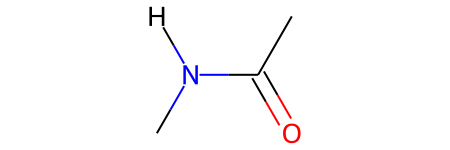

In [52]:
Chem.MolFromSmarts('[#6]-[#6](=[#8])-[#7](-[#6])-[H]')

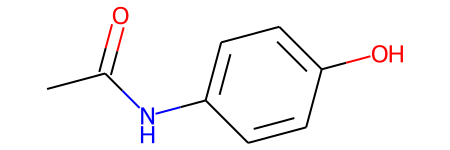

In [53]:
Chem.MolFromSmiles('CC(=O)Nc1ccc(O)cc1')

## Active Fragment Database (n=0)

### Dask dataframe

In [46]:
ActiveFragmentDBDask=dd.read_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDBDask')
ActiveFragmentDBDask=client.persist(ActiveFragmentDBDask)

In [52]:
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='[#8]-[Si]'].compute()
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='[Si]-[#8]'].compute()
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='Error'].compute()

,ActiveFragments,Smiles
SubstanceID,,
33195,[#8]-[Si],CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
33195,[#8]-[Si],CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
41874,[#8]-[Si],C[Si](C)(C)OC1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)...
41874,[#8]-[Si],C[Si](C)(C)OC1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)...
47408,[#8]-[Si],C[Si](C)(C)OC[C@@H](O[Si](C)(C)C)[C@@H]1O[C@H]...
...,...,...
32975456,[#8]-[Si],CCCCCC(=O)C=C[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C)...
32983795,[#8]-[Si],CC(C)(C)C(=O)O[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C...
32983795,[#8]-[Si],CC(C)(C)C(=O)O[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C...


,ActiveFragments,Smiles
SubstanceID,,
1112,[Si]-[#8],C[Si]1(C)CCCO1
1132,[Si]-[#8],C[Si]1(C)CCCCO1
1181,[Si]-[#8],C[Si]1(C)COCCO1
1193,[Si]-[#8],C[Si]1(C)CCCCCO1
47408,[Si]-[#8],C[Si](C)(C)OC[C@@H](O[Si](C)(C)C)[C@@H]1O[C@H]...
...,...,...
32931896,[Si]-[#8],CC(C)(C)[Si](C)(C)OCC[C@@H](CCC[C@@H](O)CO)O[S...
32942630,[Si]-[#8],CC(C)(C)[Si](C)(C)OCCCCC(O)[C@]1(C)C=C[C@@H](C...
32948180,[Si]-[#8],CC(C)(C)[Si](C)(C)OC[C@H]1O[C@@H](n2ccc(NC(=O)...


,ActiveFragments,Smiles
SubstanceID,,
71120,Error,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
2642603,Error,c1=c\c2ccc(cc2)-c2ccccc2-c2ccc/1cc2
3191701,Error,O=c1c2c(c(=O)c3c1c1c4cccc5cccc(c54)c1c1c4cccc5...
3894775,Error,COc1cc(CC[N+](C)(C)C)c2c(c1OC)-o-c1ccc(cc1)/c=...
3957813,Error,[Na+].c1ccc([GeH2-](c2ccccc2)c2ccccc2)cc1
...,...,...
32826420,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826421,Error,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826422,Error,CN(C)CCN(C)C.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[S...


### Pandas dataframe

In [11]:
ActiveFragmentDB=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB.pickle")

In [15]:
ActiveFragmentDB

,,Smiles
ActiveFragments,SubstanceID,
[#6](=[#8])-[#8],925,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1
[#6](-[#7])-[#7],925,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1
[#8]-[#6]=[#8],925,CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1
[#6](=[#8])-[#8],929,CCCCCC(=O)OCC1(COC(=O)CCCCC)Nc2cccc3ccc(C4C(=O...
[#6](-[#7])-[#7],929,CCCCCC(=O)OCC1(COC(=O)CCCCC)Nc2cccc3ccc(C4C(=O...
...,...,...
[#8]-[Si],32983885,C=C(CO[Si](C)(C)C(C)(C)C)[C@@H]1[C@@H]2CC[C@H]...
[#6](=[#8])-[#8],32983885,C=C(CO[Si](C)(C)C(C)(C)C)[C@@H]1[C@@H]2CC[C@H]...
[#35],32984157,Brc1ccc2ncccc2c1.Cl


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [14]:
ActiveFragmentDB.loc['[#8]-[Si]']
ActiveFragmentDB.loc['[Si]-[#8]']
ActiveFragmentDB.loc['Error']

,Smiles
SubstanceID,
33195,CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
33195,CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
41874,C[Si](C)(C)OC1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)...
41874,C[Si](C)(C)OC1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)...
47408,C[Si](C)(C)OC[C@@H](O[Si](C)(C)C)[C@@H]1O[C@H]...
...,...
32975456,CCCCCC(=O)C=C[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C)...
32983795,CC(C)(C)C(=O)O[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C...
32983795,CC(C)(C)C(=O)O[C@@H]1[C@H](O[Si](C)(C)C(C)(C)C...


,Smiles
SubstanceID,
1112,C[Si]1(C)CCCO1
1132,C[Si]1(C)CCCCO1
1181,C[Si]1(C)COCCO1
1193,C[Si]1(C)CCCCCO1
47408,C[Si](C)(C)OC[C@@H](O[Si](C)(C)C)[C@@H]1O[C@H]...
...,...
32931896,CC(C)(C)[Si](C)(C)OCC[C@@H](CCC[C@@H](O)CO)O[S...
32942630,CC(C)(C)[Si](C)(C)OCCCCC(O)[C@]1(C)C=C[C@@H](C...
32948180,CC(C)(C)[Si](C)(C)OC[C@H]1O[C@@H](n2ccc(NC(=O)...


,Smiles
SubstanceID,
71120,C=Cc1cc(OC)c(OC)c2c1/c=c\c1ccc(cc1)-o-c1c(c(C=...
2642603,c1=c\c2ccc(cc2)-c2ccccc2-c2ccc/1cc2
3191701,O=c1c2c(c(=O)c3c1c1c4cccc5cccc(c54)c1c1c4cccc5...
3894775,COc1cc(CC[N+](C)(C)C)c2c(c1OC)-o-c1ccc(cc1)/c=...
3957813,[Na+].c1ccc([GeH2-](c2ccccc2)c2ccccc2)cc1
...,...
32826420,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826421,C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)...
32826422,CN(C)CCN(C)C.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[S...


As shown above, it is possible to group compounds and their smiles based on active fragment. Some records encountered errors (238). This is because of incorrect RDKit translation of molfile to smiles strings. Whilst the issue is resolved by reading smarts instead of smiles, the carrierfrags function will need to be adapted.

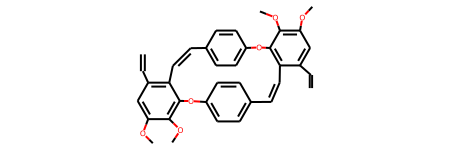

RDKit ERROR: [05:26:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 10 11 12 13 14 15 16 17 18 19 21 22 23 26 27 30 33 34 35 36 37 38 39 40
RDKit ERROR: 
RDKit ERROR: [05:26:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 10 11 12 13 14 15 16 17 18 19 21 22 23 26 27 30 33 34 35 36 37 38 39 40
RDKit ERROR: 


In [157]:
errormol=Chem.MolFromMolFile(substancedb.loc[71120,'MolFileAddress'])
errormol
Chem.MolFromSmiles(Chem.MolToSmiles(errormol))
Chem.MolFromSmiles('C=Cc1cc(OC)c(OC)c2c1/c=c\\c1ccc(cc1)-o-c1c(c(C=C)cc(OC)c1OC)/c=c\\c1ccc(cc1)-o-2')

In [196]:
deem=Chem.MolFromSmarts(Chem.MolToSmarts(errormol))
Chem.SanitizeMol(deem)
deem.UpdatePropertyCache(strict=False)
deem=Chem.rdmolops.AddHs(deem)
IFG(deem)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

[IFG(atomIds=(36,), atoms='O', type='cOC'),
 IFG(atomIds=(6,), atoms='O', type='cOC'),
 IFG(atomIds=(38,), atoms='O', type='cOC'),
 IFG(atomIds=(8,), atoms='O', type='cOC'),
 IFG(atomIds=(40, 41), atoms='C=C', type='cC=C'),
 IFG(atomIds=(10, 11), atoms='C=C', type='cC=C'),
 IFG(atomIds=(20,), atoms='o', type='c-o-c'),
 IFG(atomIds=(29,), atoms='o', type='c-o-c')]

Two cells below check whether it is faster to load a mol from molfile, or generating it from smiles. The latter is slightly faster, but the former is useful in cases where the smiles is incorrect as is the case above.

In [189]:
%%timeit -n 1 -r 1
Chem.MolFromMolFile(substancedb.loc[47408,'MolFileAddress'])

1.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [190]:
%%timeit -n 1 -r 1
Chem.MolFromSmiles(substancedb.loc[47408,'Smiles'])

533 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [167]:
Chem.MolToSmarts(errormol)

'[#6]12:[#6](:[#6](:[#6]:[#6](:[#6]:1-[#8]-[#6])-[#8]-[#6])-[#6]=[#6])/[#6]=[#6]\\[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6]1:[#6](/[#6]=[#6]\\[#6]3:[#6]:[#6]:[#6](-[#8]-2):[#6]:[#6]:3):[#6](:[#6]:[#6](:[#6]:1-[#8]-[#6])-[#8]-[#6])-[#6]=[#6]'

In [117]:
len(ActiveFragmentDB.loc['[#8]-[Si]','Smiles'].values)

489890

In [121]:
ActiveFragmentDB.index.unique()

Index(['[#6](=[#8])-[#8]', '[#6](-[#7])-[#7]', '[#8]-[#6]=[#8]', '[#6]=[#8]',
       '[#7]-[#6]-[#7]', '[#8]=[#6]-[#8]', '[#8]-[#6](-[#8])-[#6]=[#8]',
       '[#8]', '[#8]-[#6](-[#8])-[#6](-[#8])-[#8]',
       '[#8]-[#6](=[#8])-[#6](-[#8])-[#7]-[#6](-[#7]-[#6](-[#8])-[#6](=[#8])-[#8])=[#8]',
       ...
       '[#7](-[#6]=[#8])-[#6](-[#7]-[#6]=[#8])=[#6]-[#15]',
       '[#8]-[#6](=[#8])-[#6]1=[#6]-[#6](-[#6]=[#8])=[#6]-[#6]-1=[#6]-[#7]',
       '[Ni].[Ni].[Zn].[Zn].[Zn].[Zn].[Zn].[Zn]',
       '[#6]-[#6](-[#6])-[#6]1:[#6]:[#6]:[#6]:[#6](-[#6](-[#6])-[#6]):[#6]:1-[#7]=[#6](-[#6]=[#6](-[#7-]-[#6]1:[#6](-[#6](-[#6])-[#6]):[#6]:[#6]:[#6]:[#6]:1-[#6](-[#6])-[#6])-[#6](-[#6])(-[#6])-[#6])-[#6](-[#6])(-[#6])-[#6].[#8]=[#6](-[#8-])-[#8-].[Li+].[Ni+2]',
       '[#17-]-[Pd+2](-[#17-])(-[#17-])-[#17-].[#6H]1(-[#6])-[#6]-[#6]-[#6H](-[#6](-[#6])-[#6])-[#6H](-[#8]-[#6]-[#7]2:[#6]:[#6]:[#7+](-[#6]-[#8]-[#6H]3-[#6]-[#6H](-[#6])-[#6]-[#6]-[#6H]-3-[#6](-[#6])-[#6]):[#6]:2)-[#6]-1',
       '[#8]-[#6](=[#8

In [107]:
ActiveFragmentDB.loc[ActiveFragmentDB['SubstanceID']==33195,'Smiles']

ActiveFragments
[#8]-[#6]-[#8]      CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
[#8]-[Si]           CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
[#6](=[#8])-[#8]    CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
[#8]-[Si]           CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@...
Name: Smiles, dtype: object

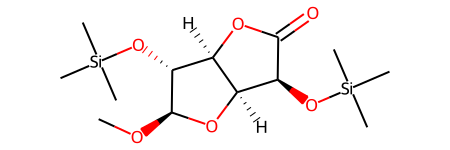

['[#8]-[#6]-[#8]', '[#8]-[Si]', '[#6](=[#8])-[#8]', '[#8]-[Si]']

In [118]:
Chem.MolFromSmiles('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C')
getCarrierFrags('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C',0)

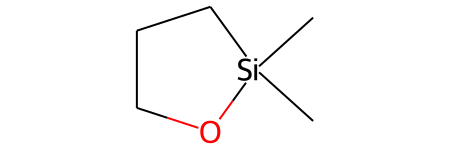

In [110]:
Chem.MolFromSmiles('C[Si]1(C)CCCO1')

In [111]:
Chem.MolToSmiles(Chem.MolFromSmarts('[Si]-[#8]'))

'O[SiH3]'

In [113]:
IFG(Chem.MolFromSmiles('C[Si]1(C)CCCO1'))
IFG(Chem.MolFromSmiles('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C'))

[IFG(atomIds=(1, 6), atoms='O[Si]', type='CO[Si](C)(C)C')]

[IFG(atomIds=(1, 2, 3), atoms='OCO', type='CO[C@@H](C)OC'),
 IFG(atomIds=(6, 7), atoms='O[Si]', type='C[Si](C)(C)OC'),
 IFG(atomIds=(11, 12, 13), atoms='O=CO', type='COC(C)=O'),
 IFG(atomIds=(16, 17), atoms='O[Si]', type='C[Si](C)(C)OC')]

In [114]:
getCarrierFrags('C[Si]1(C)CCCO1',0)

['[Si]-[#8]']

In [73]:
ActiveFragmentDB.loc[1000001,'ActiveFragments']

['[#17]', '[#6]#[#7]']

In [80]:
ActiveFragmentDB.loc[1000001,'Smiles']
ActiveFragmentDB.loc[1000001,'SubstanceID']

'Cc1cc(C#N)c(C)cc1Cl'

2613840

In [75]:
getCarrierFrags(ActiveFragmentDB.loc[1000001,'Smiles'],0)

['[#17]', '[#6]#[#7]']

In [47]:
getCarrierFrags(testset.loc[testset['SubstanceID']==28713377,'Smiles'][0],0)

['[#8]',
 '[#8]=[#6]-[#8]',
 '[#6](=[#8])-[#8]',
 '[#7]',
 '[#6](=[#8])-[#8-]',
 '[Co+2]']

In [48]:
dfaf

,ActiveFragments
0,"[[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]..."
1,"[[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]..."
2,"[[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]..."
3,"[[#8]=[#6]-[#8], [#6](-[#7])-[#7], [#8]-[#6]=[..."
4,"[[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]..."
...,...
1008081,"[[#6](=[#8])-[#8], [#8], [#7], [#7+](=[#8])-[#..."
1008082,"[[#6](=[#8])-[#8], [#8]-[Si], [#8]-[#6]-[#8], ..."
1008083,"[[#6]=[#6], [#8]-[Si], [#16](=[#8])=[#8], [#6]..."
1008084,"[[#6]=[#6], [#8]-[Si], [#6](=[#8])-[#8]]"


In [18]:
dfafdask=dd.from_pandas(dfaf,npartitions=16)

In [61]:
dfafdask.loc[0,'ActiveFragments'].compute()

0    [[#6](=[#8])-[#8], [#6](-[#7])-[#7], [#8]-[#6]...
0                         [[#8]=[#6]-[#7], [#7], [#9]]
0               [[#6]=[#6], [#6]=[#6]-[Se], [#6]#[#7]]
0                [[#6]=[#6], [#15](=[#8])(-[#8])-[#8]]
0                   [[#8], [#6]=[#6], [#7], [#8]-[Si]]
0                          [[#6]=[#6], [#8]-[#6]=[#8]]
0    [[#6]=[#6], [#8]-[#6]=[#8], [#8]-[#6]-[#7], [#...
0    [[#6]=[#6], [#7]-[#6](=[#8])-[#7]-[#6]-[#8], [...
0    [[#8]-[#6]-[#8]-[#6]=[#8], [#8], [#6](-[#16])-...
0    [[#6](=[#8])-[#8], [#8]-[#6]-[#8], [#6]=[#6], ...
0                                    [[#7], [#6]=[#8]]
0    [[#8], [#8]=[#6]-[#8], [#6](=[#8])-[#8], [#7],...
0                          [[#7]-[#6]=[#8], [#6]=[#8]]
0          [[#8], [#6]#[#6], [#7+], [#6]#[#6], [#35-]]
Name: ActiveFragments, dtype: object

In [406]:
testset.loc[0,'Smiles']

'CC(=O)OCC1(COC(C)=O)Nc2cccc3cccc(c23)N1'

In [229]:
substancedbdask.loc[substancedbdask['Smiles']=='COC(OC)C(=O)COC(C)=O'].compute()

,MolFileAddress,Smiles,Error
SubstanceID,,,
941,/home/projects/graph/data/batch_5000000/941,COC(OC)C(=O)COC(C)=O,No


In [230]:
substancedb.loc[substancedb['Smiles']=='COC(OC)C(=O)COC(C)=O']

,MolFileAddress,Smiles,Error
SubstanceID,,,
941,/home/projects/graph/data/batch_5000000/941,COC(OC)C(=O)COC(C)=O,No


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


# Conclusion

Further results have been discussed/included in Preidct_Impurities.ipynb

In [12]:
%whos

Variable   Type      Data/Info
------------------------------
autopep8   module    <module 'autopep8' from '<...>te-packages/autopep8.py'>
json       module    <module 'json' from '/hom<...>hon3.8/json/__init__.py'>


In [6]:
substancedb

,,MolFileAddress,Error,>1 Compound
Smiles,SubstanceID,,,
CC(C)(C)[C@@H]1CC[C@@](C)(F)[C@H](Br)C1,6890270,/home/projects/graph/data/batch_6500000/6890270,No,False
Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,27615522,/home/projects/graph/data/batch_6500000/27615522,No,False
[Gd+3].[Na+].[O-]B([O-])[O-].[Tb+3],29164535,/home/projects/graph/data/batch_6500000/29164535,No,True
Nc1cc(F)c(N2CC(F)C2)c(F)c1,11230426,/home/projects/graph/data/batch_6500000/11230426,No,False
CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2)c(OCCCC)c1,9019791,/home/projects/graph/data/batch_6500000/9019791,No,False
...,...,...,...,...
CCOC(=O)C(CC)(CC)P(=O)(OCC)OCC,26761831,/home/projects/graph/data/batch_12600000/26761831,No,False
N#CC(COC(=O)c1ccccc1)OC(=O)c1ccccc1,3409746,/home/projects/graph/data/batch_12600000/3409746,No,False
CN(O)C(CCC(C)(C)O)C1=CCCCC1,6138726,/home/projects/graph/data/batch_12600000/6138726,No,False


Finding an entry by Smiles and Reaxys ID

In [14]:
substancedb.xs('CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+]')
substancedb.xs('CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+]').index[0]

,MolFileAddress,Error,>1 Compound
SubstanceID,,,
22727365,/home/projects/graph/data/batch_12600000/22727365,No,True


22727365

Finding an entry by Reaxys ID and Smiles

In [15]:
substancedb.xs(22727365,level=1)
substancedb.xs(22727365,level=1).index[0]

,MolFileAddress,Error,>1 Compound
Smiles,,,
CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+],/home/projects/graph/data/batch_12600000/22727365,No,True


'CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+]'